In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss

import pickle

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibratedClassifierCV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import ttest_ind, kruskal, mannwhitneyu




Para crear la segmentación de la cartera por probabilidad de default, debemos incluir en el dataframe de variables más importantes la PD estimada. Pero dicho dataset fue previamente escalado mediante MinMaxScaler antes de ser modelizado, y lo que queremos ahora es incluir a dicho dataframe una nueva variable que no está escalada, pese a encontrarse dentro del rango 0-1 por ser una probabilidad. Pero dicha variable, al no ser escalada junto con el resto de variables es posible que no siga la misma distribución.

Es importante analizar que la distribución de la PD añadida no sea muy distinta de la distribución del resto de variables ya escaladas. Debería:
- Tener una distribución homogénea
- No tener valores extremadamente concentrados en un rango

### <p style="color:red;">1. CARGA DE DATASETS</p>

Cargamos los datasets necesarios. Nos vamos a centar en el modelo que mejor capacidad predictiva a mostrado (**XGBoost**) y el modelo más utilizado por la industria financiera hasta ahora, para la estimación de los parámetros de modelos de riesgo de crédito (**Regresión Logística**).

In [2]:
df_PD_lr = pd.read_csv('df_PD_lr.csv')
df_PD_rf = pd.read_csv('df_PD_rf.csv')
df_PD_xgb = pd.read_csv('df_PD_xgb.csv')
df_PD_nn = pd.read_csv('df_PD_nn.csv')

### <p style="color:red;">2. COMPARATIVA DE LA DISTRIBUCIÓN DE LA PD ESTIMADA CON EL RESTO DE VARIABLES</p>

<p style="color:red;">2.1 REGRESIÓN LOGÍSTICA

In [3]:
df_PD_lr

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada
0,0.000000,0.708891,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.942905
1,0.000000,0.175197,0.225000,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.624584
2,0.000000,0.085573,0.094853,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.530864
3,0.000000,0.202540,0.264706,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.651728
4,0.000000,0.405081,0.558824,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.142857,0.784474
...,...,...,...,...,...,...,...,...,...,...,...
402884,0.132740,0.142902,0.264706,0.0,0.0,0.165740,0.105162,0.0,1.000000,1.000000,0.390964
402885,0.318573,0.342967,0.676471,0.0,0.0,0.397778,0.252384,0.0,1.000000,1.000000,0.444955
402886,0.125985,0.225944,0.352941,0.0,0.0,0.310595,0.065875,0.0,1.000000,1.000000,0.669790
402887,0.126584,0.211600,0.323529,0.0,0.0,0.360564,0.055453,0.0,1.000000,1.000000,0.709053


En primer lugar, analizamos la distribución de la PD estimada por el modelo de Regresión Logística

count    402889.000000
mean          0.625174
std           0.191451
min           0.000272
25%           0.500525
50%           0.629389
75%           0.769230
max           0.999981
Name: PD_estimada, dtype: float64


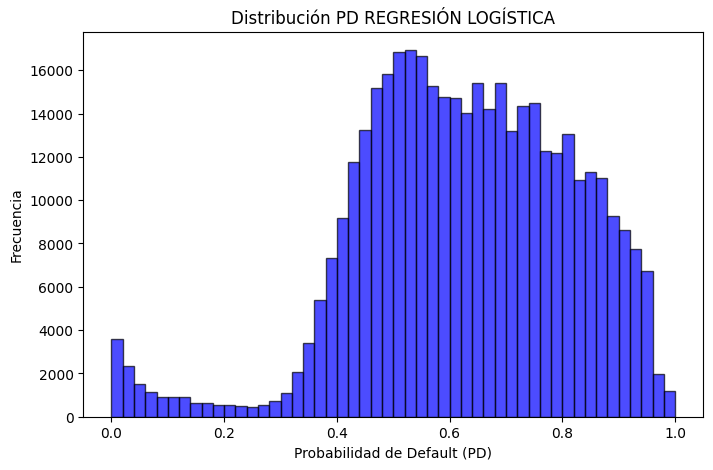

In [4]:
# Ver resumen estadístico
print(df_PD_lr['PD_estimada'].describe())

# Graficar la distribución de la PD
plt.figure(figsize=(8,5))
plt.hist(df_PD_lr['PD_estimada'], bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Probabilidad de Default (PD)")
plt.ylabel("Frecuencia")
plt.title("Distribución PD REGRESIÓN LOGÍSTICA")
plt.show()

En segundo lugar, analizamos el resto de risk drivers, tanto analítica como graficamente

In [5]:
df_PD_lr.describe()

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada
count,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000
mean,0.087413,0.259288,0.403273,0.000626,0.000082,0.125286,0.065638,0.000182,0.462538,0.560981,0.625174
std,0.087899,0.161936,0.241342,0.011369,0.004507,0.126459,0.080207,0.009741,0.279219,0.244030,0.191451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000272
25%,0.027422,0.135645,0.211765,0.000000,0.000000,0.035432,0.018895,0.000000,0.250000,0.357143,0.500525
50%,0.062860,0.232310,0.353676,0.000000,0.000000,0.083986,0.042610,0.000000,0.416667,0.571429,0.629389
75%,0.118198,0.364144,0.558824,0.000000,0.000000,0.173623,0.081828,0.000000,0.666667,0.785714,0.769230
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999981


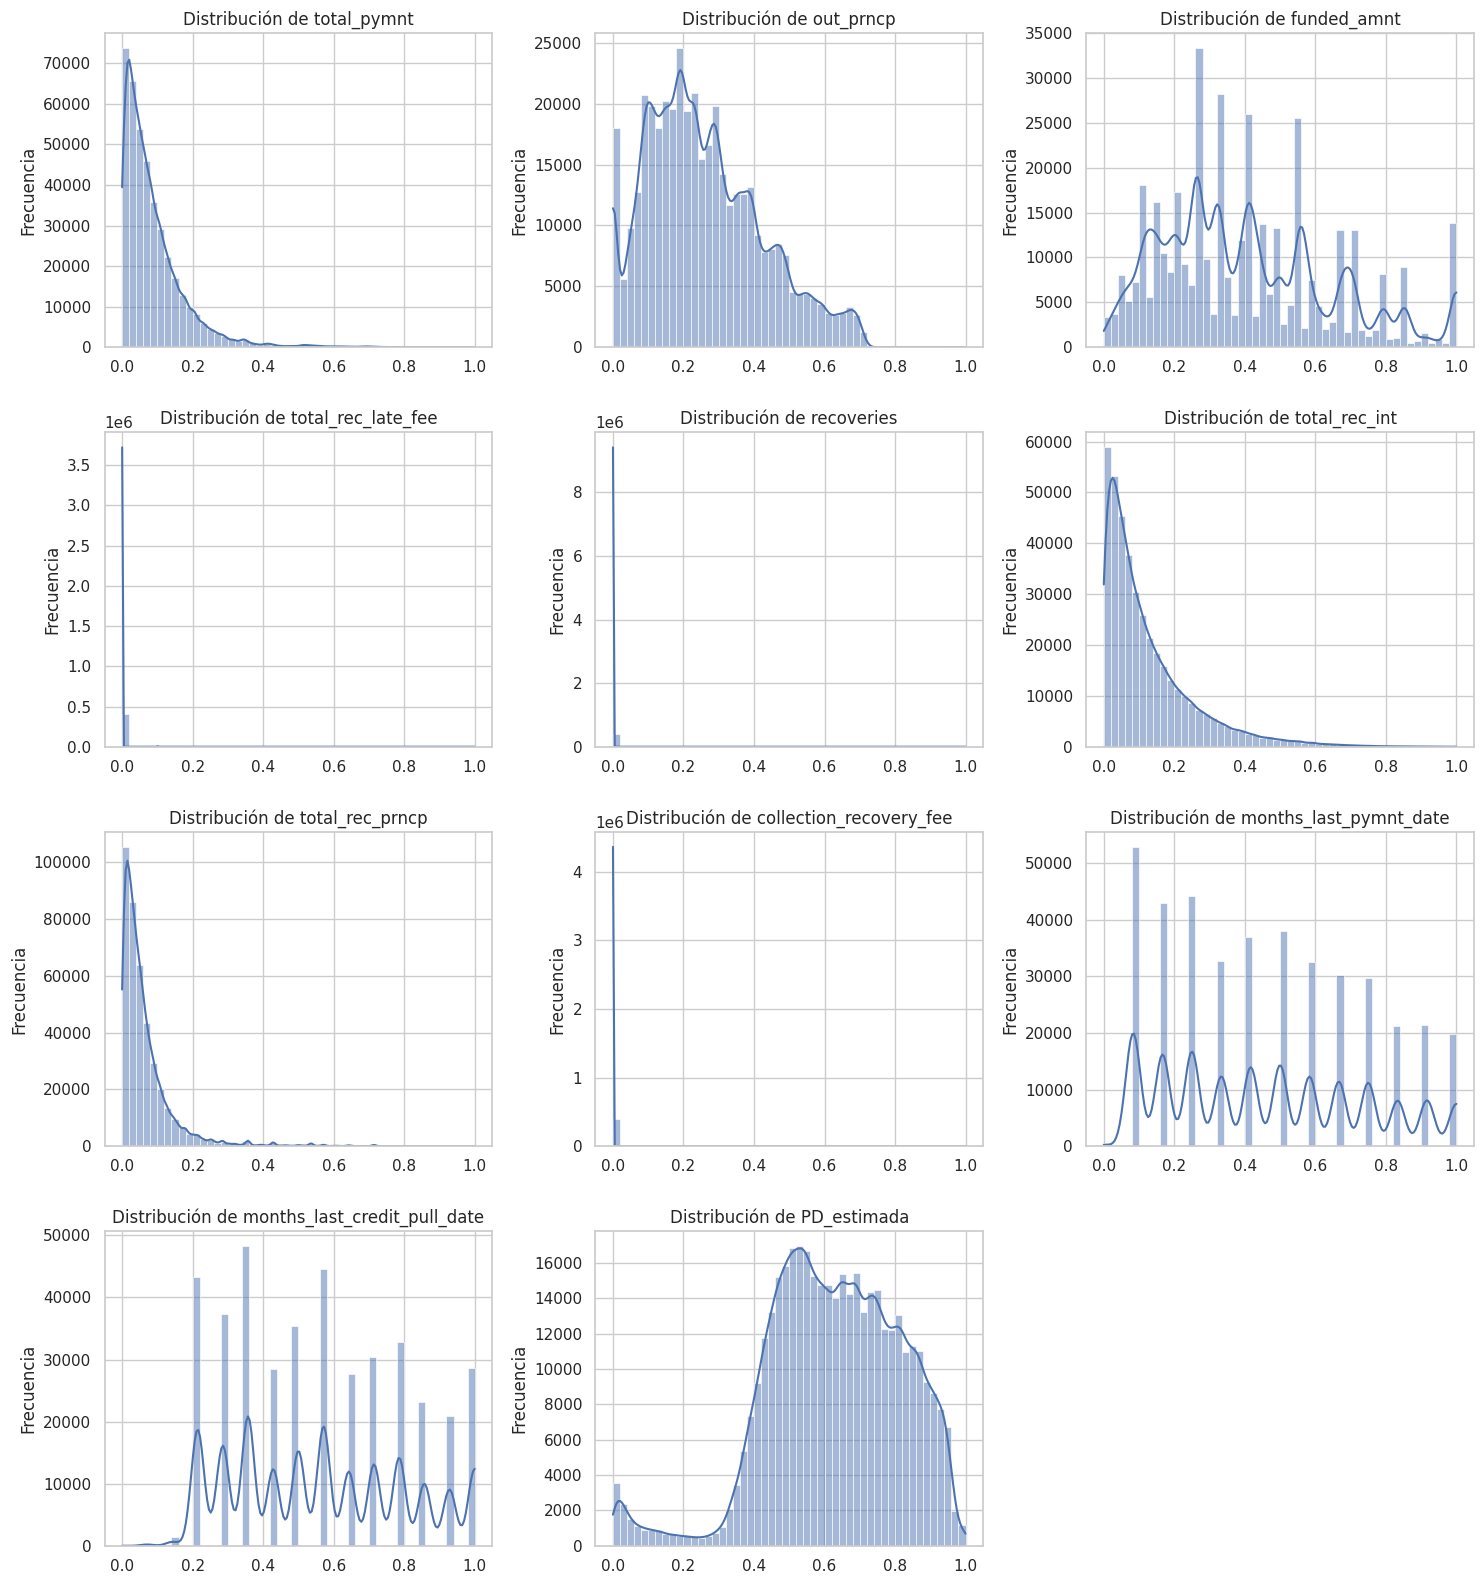

In [6]:
# Configuración de estilo
sns.set(style="whitegrid")

# Número de variables en el dataset
num_vars = len(df_PD_lr.columns)

# Crear subgráficos en una cuadrícula
fig, axes = plt.subplots(nrows=(num_vars // 3) + 1, ncols=3, figsize=(15, 4 * ((num_vars // 3) + 1)))
axes = axes.flatten()  # Convertir en un array 1D para iterar fácilmente

# Generar histogramas para cada variable en el dataset
for i, col in enumerate(df_PD_lr.columns):
    sns.histplot(df_PD_lr[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")

# Ocultar ejes vacíos si hay menos variables que espacios en la cuadrícula
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar diseño
plt.tight_layout()
plt.show()

1. Todas las variables han sido escaladas en el rango [0,1], lo que significa que la PD ya cumple con este requisito.
2. Media y Desviación Estándar:
   - La media de la PD (0.326) es similar a la de otras variables como total_pymnt (0.086), funded_amnt (0.405), y loan_amnt (0.405).
   - La desviación estándar de la PD (0.195) es comparable a la de otras variables (funded_amnt: 0.242, loan_amnt: 0.242), lo que indica que la PD no tiene una varianza mucho mayor o menor que las demás.
3. Distribución Cuartílica:
   - El 25% de la PD está por debajo de 0.17, la mediana es 0.316 y el 75% está por debajo de 0.45, lo que indica que la PD tiene una distribución relativamente uniforme en comparación con otras variables como funded_amnt y loan_amnt.
   - No hay valores extremos problemáticos (mínimo y máximo dentro del rango [0,1]).

Las estadísticas muestran que la PD ya tiene una distribución similar a otras variables y está en el mismo rango [0,1], por lo que se puede agregar al dataset escalado, sin tener que deshacer el escalado previamente hecho y tener que volver a escalarlo con todas las variables.

In [7]:
#Ya lo incluimos anteriormente
df_PD_lr.head()

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada
0,0.0,0.708891,1.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.942905
1,0.0,0.175197,0.225000,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.624584
2,0.0,0.085573,0.094853,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.530864
3,0.0,0.202540,0.264706,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.651728
4,0.0,0.405081,0.558824,0.0,0.0,0.0,0.0,0.0,0.083333,0.142857,0.784474


<p style="color:red;">2.2 RANDOM FOREST

Solo graficamos la distribución de la PD del modelo Random Forest a título informativo, ya que como hemos comentado anteriormente, no nos vamos a centrar en este modelo.

In [8]:
df_PD_rf

,total_acc,out_prncp,pub_rec,out_prncp_inv,delinq_2yrs,total_rec_int,dti,inq_last_6mths,open_acc,funded_amnt_inv,...,funded_amnt,loan_amnt,revol_util,total_rec_prncp,int_rate,revol_bal,total_pymnt_inv,total_pymnt,annual_inc,PD_estimada
0,0.254545,0.708891,0.000000,0.708891,0.000000,0.000000,0.000646,0.000000,0.197531,1.000000,...,1.000000,1.000000,0.141969,0.000000,0.281791,0.019626,0.000000,0.000000,0.013474,0.569005
1,0.121212,0.175197,0.000000,0.175197,0.000000,0.000000,0.000728,0.000000,0.172840,0.227273,...,0.225000,0.225000,0.138342,0.000000,0.000000,0.009840,0.000000,0.000000,0.010526,0.420532
2,0.012121,0.085573,0.000000,0.085573,0.051282,0.000000,0.001522,0.000000,0.061728,0.097507,...,0.094853,0.094853,0.127461,0.000000,0.402619,0.001454,0.000000,0.000000,0.003684,0.289892
3,0.115152,0.202540,0.000000,0.202540,0.000000,0.000000,0.003104,0.166667,0.111111,0.266862,...,0.264706,0.264706,0.211917,0.000000,0.281791,0.007989,0.000000,0.000000,0.004474,0.466420
4,0.084848,0.405081,0.000000,0.405081,0.000000,0.000000,0.001078,0.000000,0.061728,0.560117,...,0.558824,0.558824,0.291192,0.000000,0.230672,0.010817,0.000000,0.000000,0.006632,0.543223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402884,0.066667,0.142902,0.011628,0.142902,0.000000,0.165740,0.002869,0.000000,0.098765,0.266862,...,0.264706,0.264706,0.425389,0.105162,0.281791,0.019296,0.132740,0.132740,0.003263,0.252368
402885,0.115152,0.342967,0.000000,0.342967,0.000000,0.397778,0.000390,0.166667,0.049383,0.677419,...,0.676471,0.676471,0.437824,0.252384,0.281791,0.011851,0.318573,0.318573,0.008316,0.214477
402886,0.109091,0.225944,0.011628,0.225944,0.000000,0.310595,0.003090,0.000000,0.098765,0.354839,...,0.352941,0.352941,0.317617,0.065875,0.450782,0.015164,0.125985,0.125985,0.003684,0.330028
402887,0.096970,0.211600,0.000000,0.211600,0.025641,0.360564,0.002719,0.333333,0.197531,0.325513,...,0.323529,0.323529,0.158549,0.055453,0.619772,0.011346,0.126584,0.126584,0.006779,0.385008


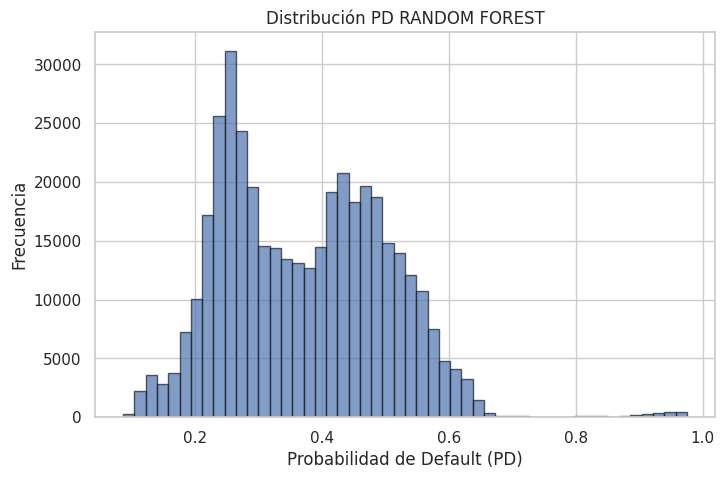

In [9]:
# Ver resumen estadístico
# print(PD_modelo_lr.describe())

# Graficar la distribución de la PD
plt.figure(figsize=(8,5))
plt.hist(df_PD_rf['PD_estimada'], bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Probabilidad de Default (PD)")
plt.ylabel("Frecuencia")
plt.title("Distribución PD RANDOM FOREST")
plt.show()

La distribución del modelo Random Forest no se encuentra tan bien distribuida como el modelo de Regresión Logística, por lo que no deberíamos incluir directamente al df la PD estimada.

<p style="color:red;">2.3 XGBOOST

In [10]:
df_PD_xgb

,funded_amnt,installment,out_prncp,out_prncp_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,term_months,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada
0,1.000000,0.528679,0.708891,0.708891,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.083333,0.214286,0.999925
1,0.225000,0.162774,0.175197,0.175197,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.083333,0.214286,0.993458
2,0.094853,0.081987,0.085573,0.085573,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.083333,0.214286,0.734232
3,0.264706,0.135854,0.202540,0.202540,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.083333,0.214286,0.971217
4,0.558824,0.284412,0.405081,0.405081,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.083333,0.142857,0.998612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402884,0.264706,0.213362,0.142902,0.142902,0.105162,0.165740,0.0,0.0,0.009286,0.0,1.000000,1.000000,0.134447
402885,0.676471,0.541856,0.342967,0.342967,0.252384,0.397778,0.0,0.0,0.022287,0.0,1.000000,1.000000,0.126744
402886,0.352941,0.202036,0.225944,0.225944,0.065875,0.310595,0.0,0.0,0.008838,1.0,1.000000,1.000000,0.094520
402887,0.323529,0.203301,0.211600,0.211600,0.055453,0.360564,0.0,0.0,0.008888,1.0,1.000000,1.000000,0.116781


count    402889.000000
mean          0.323009
std           0.338683
min           0.000003
25%           0.087403
50%           0.184364
75%           0.368006
max           1.000000
Name: PD_estimada, dtype: float64


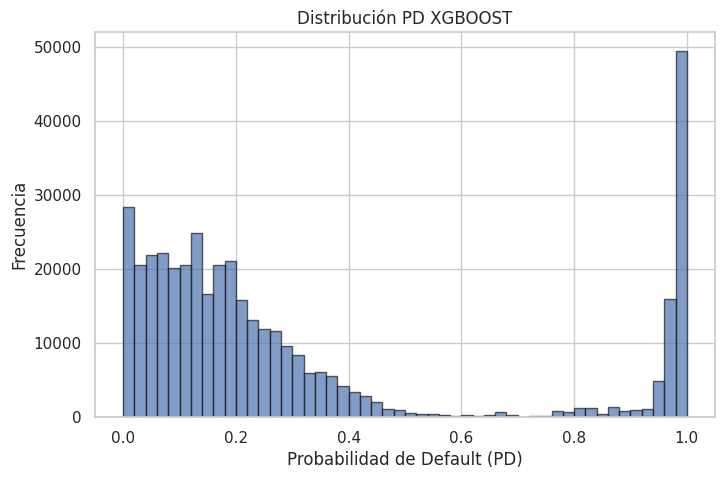

In [11]:
# Ver resumen estadístico
print(df_PD_xgb['PD_estimada'].describe())

# Graficar la distribución de la PD
plt.figure(figsize=(8,5))
plt.hist(df_PD_xgb['PD_estimada'], bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Probabilidad de Default (PD)")
plt.ylabel("Frecuencia")
plt.title("Distribución PD XGBOOST")
plt.show()

In [12]:
df_PD_xgb.describe()

,funded_amnt,installment,out_prncp,out_prncp_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,term_months,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada
count,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000,402889.000000
mean,0.403273,0.279822,0.259288,0.259180,0.065638,0.125286,0.000626,0.000082,0.019311,0.316924,0.462538,0.560981,0.323009
std,0.241342,0.163666,0.161936,0.161864,0.080207,0.126459,0.011369,0.004507,0.047764,0.465278,0.279219,0.244030,0.338683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003
25%,0.211765,0.162173,0.135645,0.135603,0.018895,0.035432,0.000000,0.000000,0.007036,0.000000,0.250000,0.357143,0.087403
50%,0.353676,0.243977,0.232310,0.232129,0.042610,0.083986,0.000000,0.000000,0.010619,0.000000,0.416667,0.571429,0.184364
75%,0.558824,0.370773,0.364144,0.364034,0.081828,0.173623,0.000000,0.000000,0.016317,1.000000,0.666667,0.785714,0.368006
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


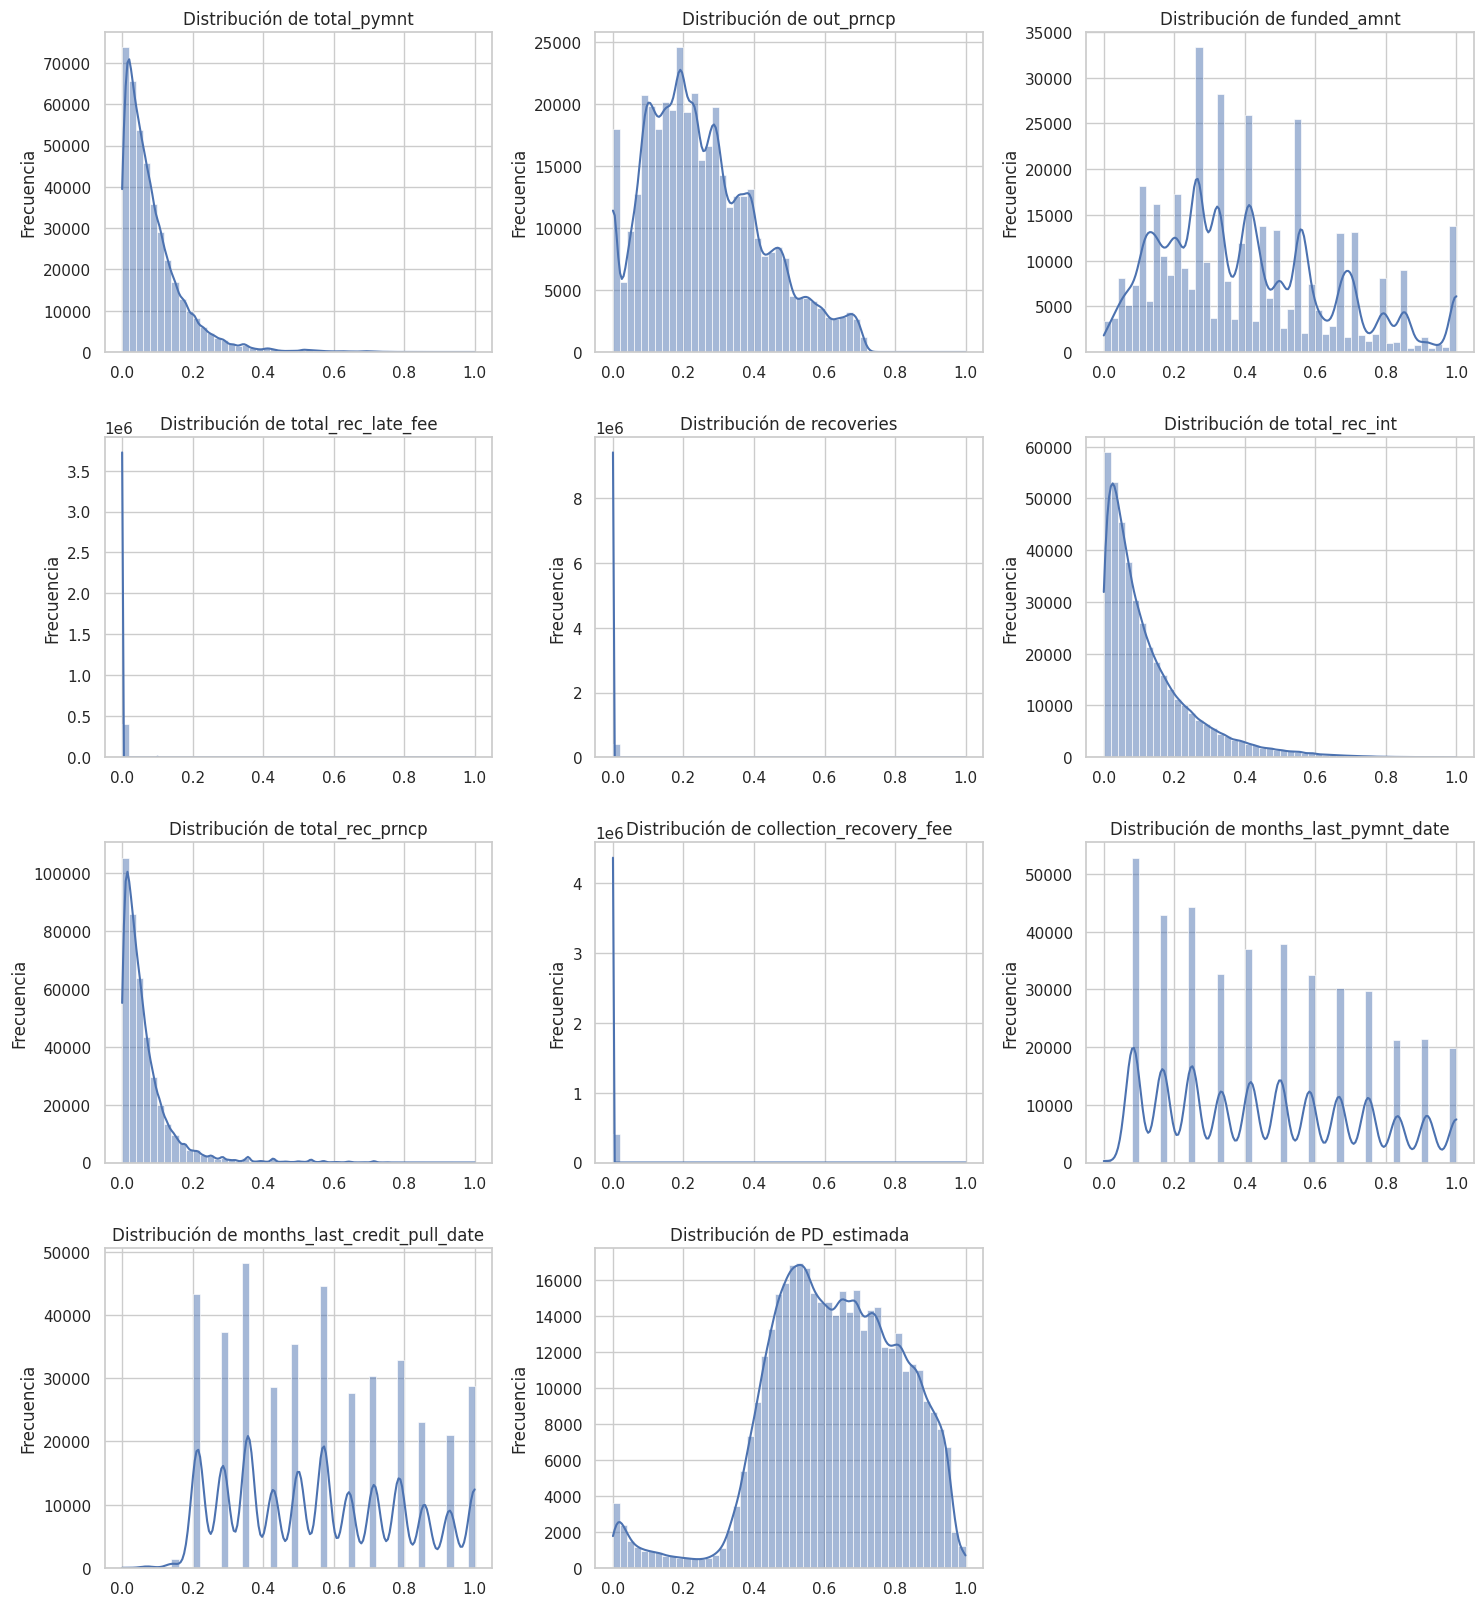

In [13]:
# Configuración de estilo
sns.set(style="whitegrid")

# Número de variables en el dataset
num_vars = len(df_PD_xgb.columns)

# Crear subgráficos en una cuadrícula
fig, axes = plt.subplots(nrows=(num_vars // 3) + 1, ncols=3, figsize=(15, 4 * ((num_vars // 3) + 1)))
axes = axes.flatten()  # Convertir en un array 1D para iterar fácilmente

# Generar histogramas para cada variable en el dataset
for i, col in enumerate(df_PD_lr.columns):
    sns.histplot(df_PD_lr[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")

# Ocultar ejes vacíos si hay menos variables que espacios en la cuadrícula
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar diseño
plt.tight_layout()
plt.show()

# FALTA LA COMPARATIVA DE ESTADÍSTICOS ENTRE LA PD Y LAS OTRAS VARIABLES (COMO EN REG LOGÍSTICA)

<p style="color:red;">2.4. RED NEURONAL

Solo graficamos la distribución de la PD de la red neuronal a título informativo, ya que como hemos comentado anteriormente, no nos vamos a centrar en este modelo.

In [14]:
df_PD_nn

,revol_util,inq_last_6mths,purpose_wedding,tot_coll_amt,filtered_emp_title_operations,total_rec_late_fee,filtered_emp_title_other,out_prncp_inv,total_rec_int,last_pymnt_amnt,...,purpose_moving,installment,collections_12_mths_ex_med,filtered_emp_title_specialist,open_acc,tot_cur_bal,funded_amnt_inv,sub_grade_num,filtered_emp_title_technology,PD_estimada
0,0.141969,0.000000,False,0.000646,False,0.0,False,0.708891,0.000000,0.000000,...,False,0.528679,0.0,False,0.197531,0.046413,1.000000,0.312500,False,0.973103
1,0.138342,0.000000,False,0.000000,False,0.0,False,0.175197,0.000000,0.000000,...,False,0.162774,0.0,False,0.172840,0.052286,0.227273,0.000000,False,0.583518
2,0.127461,0.000000,False,0.000000,False,0.0,False,0.085573,0.000000,0.000000,...,False,0.081987,0.0,False,0.061728,0.001545,0.097507,0.375000,True,0.501357
3,0.211917,0.166667,False,0.000000,False,0.0,False,0.202540,0.000000,0.000000,...,False,0.135854,0.0,False,0.111111,0.013009,0.266862,0.312500,True,0.632588
4,0.291192,0.000000,False,0.000000,True,0.0,False,0.405081,0.000000,0.000000,...,False,0.284412,0.0,False,0.061728,0.059949,0.560117,0.203125,False,0.821395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402884,0.425389,0.000000,False,0.000000,False,0.0,False,0.142902,0.165740,0.009286,...,False,0.213362,0.0,False,0.098765,0.007987,0.266862,0.218750,False,0.287715
402885,0.437824,0.166667,False,0.000000,False,0.0,False,0.342967,0.397778,0.022287,...,False,0.541856,0.0,False,0.049383,0.044333,0.677419,0.218750,False,0.453972
402886,0.317617,0.000000,False,0.000000,False,0.0,True,0.225944,0.310595,0.008838,...,False,0.202036,0.0,False,0.098765,0.010801,0.354839,0.484375,False,0.436610
402887,0.158549,0.333333,False,0.000000,False,0.0,True,0.211600,0.360564,0.008888,...,False,0.203301,0.1,False,0.197531,0.018461,0.325513,0.656250,False,0.468336


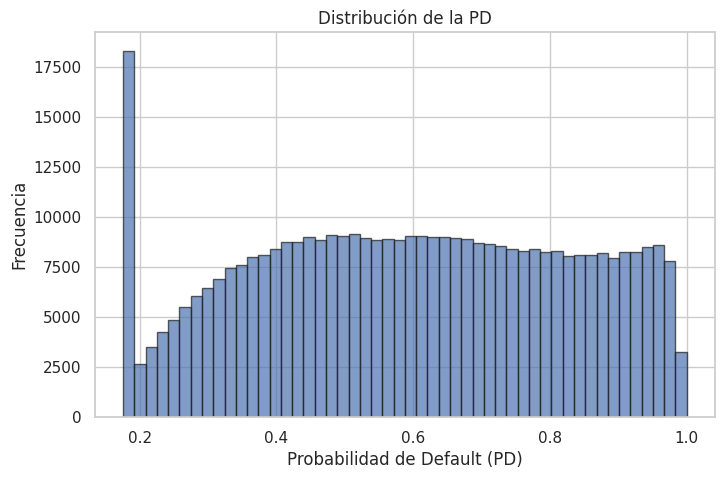

In [15]:
# Ver resumen estadístico
# print(features_explot["PD_modelo_nn"].describe())

# Graficar la distribución de la PD
plt.figure(figsize=(8,5))
plt.hist(df_PD_nn['PD_estimada'], bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Probabilidad de Default (PD)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la PD")
plt.show()

Observamos que la distribución de la PD estimada está altamente sesgada en la red neuronal.

En vista de que en muchas ocasiones modelos distintos obtienen roc_auc similares, el modelo a utilizar dependerá de para qué estemos empleando los modelos:
- Si el modelo es de clasificación pura (Decisión Sí/No. Ej: rechazar o aprobar un préstamo)--> Mejor una PD sesgada en 0 y 1 (Bimodal).
- Si el modelo se usa para asignar riesgos o tomar decisiones progresivas (Ej: modelos de scoring) --> Mejor una PD uniforme entre 0 y 1 (Probabilidad calibrada)

### <p style="color:red;">3. BUCKETIZACIÓN Y CÁLCULO DE LA DEFAULT RATE POR BUCKET</p>

Creamos 2 funciones, una segmenta por buckets manualmente y la otra segmenta por clusters aplicando KMeans (aprendizaje no supervisado), agrega la Tasa Default media por bucket/cluster y la grafica junto con la PD media estimada en el notebook anterior.

Creamos una **versión manual** de los buckets, condicionando a que la Tasa de Default observada sea creciente por buckets, que haya un número de buckets determinado y que haya el mismo número de observaciones por bucket.

In [16]:

def bucketizar_y_agregar_columna_por_bucket(df, pd_col='PD_estimada', default_col='default', num_buckets=7):
    
    # Ordenar los datos por PD estimada
    df.sort_values(by=pd_col, inplace=True)

    # Variables para iterativamente construir los buckets
    bucket_edges = [df[pd_col].min()]
    bucket_defaults = []
    min_bucket_size = len(df) // num_buckets  

    current_default_sum = 0
    current_count = 0

    for _, row in df.iterrows():
        current_default_sum += row[default_col]
        current_count += 1

        new_default_rate = current_default_sum / current_count
        if current_count >= min_bucket_size and (not bucket_defaults or new_default_rate > bucket_defaults[-1]):
            bucket_edges.append(row[pd_col])
            bucket_defaults.append(new_default_rate)
            current_default_sum = 0
            current_count = 0

    if bucket_edges[-1] < df[pd_col].max():
        bucket_edges.append(df[pd_col].max())

    # Asignar directamente los valores a los buckets en `df`
    df['PD_bin'] = pd.cut(df[pd_col], bins=bucket_edges, include_lowest=True, right=True)

    # Calcular métricas por bucket
    default_rate_by_bucket = df.groupby('PD_bin')[default_col].mean().reset_index()
    pd_mean_by_bucket = df.groupby('PD_bin')[pd_col].mean().reset_index()
    count_by_bucket = df.groupby('PD_bin').size().reset_index(name='count')

    # Unir los datos
    comparison_df = pd.merge(pd_mean_by_bucket, default_rate_by_bucket, on='PD_bin')
    comparison_df = pd.merge(comparison_df, count_by_bucket, on='PD_bin')
    comparison_df = comparison_df.reset_index(drop=True)
    comparison_df['Bucket_Num'] = comparison_df.index + 1  # Numerar los buckets

    # Asignar directamente al DataFrame original
    default_rate_by_bucket_dict = dict(zip(comparison_df['PD_bin'], comparison_df[default_col]))
    df['default_media_bucket'] = df['PD_bin'].map(default_rate_by_bucket_dict)
    df['Bucket_Num'] = df['PD_bin'].map(dict(zip(comparison_df['PD_bin'], comparison_df['Bucket_Num'])))

    # Ordenar por Bucket_Num
    df.sort_values(by='Bucket_Num', inplace=True)

    # Generar el gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Línea para PD Media Estimada
    ax1.plot(comparison_df['Bucket_Num'], comparison_df[pd_col], marker='o', linestyle='-', label='PD Media Estimada', color='b')

    # Línea para la Tasa de Default Media asegurando que es creciente
    ax1.plot(comparison_df['Bucket_Num'], comparison_df[default_col], marker='s', linestyle='--', label='Tasa de Default Media', color='r')

    # Agregar anotaciones en el gráfico
    for i, txt in enumerate(comparison_df[default_col]):
        ax1.annotate(f"{txt:.2%}", 
                     (comparison_df['Bucket_Num'][i], comparison_df[default_col][i]), 
                     textcoords="offset points", 
                     xytext=(0,5), 
                     ha='center', 
                     fontsize=10, 
                     color='red')

    for i, txt in enumerate(comparison_df[pd_col]):
        ax1.annotate(f"{txt:.2%}", 
                     (comparison_df['Bucket_Num'][i], comparison_df[pd_col][i]), 
                     textcoords="offset points", 
                     xytext=(0,-15),  
                     ha='center', 
                     fontsize=10, 
                     color='blue')

    # Configuración del eje primario
    ax1.set_xlabel('Número de Bucket')
    ax1.set_ylabel('Valor')
    ax1.set_title('Comparación de PD Media Estimada vs. Tasa de Default Media por Bucket')
    ax1.set_xticks(comparison_df['Bucket_Num'])
    ax1.set_xticklabels(comparison_df['Bucket_Num'].astype(str))
    ax1.legend(loc='upper left')
    ax1.grid()

    # Crear un segundo eje para la cantidad de operaciones
    ax2 = ax1.twinx()
    ax2.bar(comparison_df['Bucket_Num'], comparison_df['count'], alpha=0.3, color='gray', label='Número de Operaciones')

    # Configuración del eje secundario
    ax2.set_ylabel('Número de Operaciones')
    ax2.legend(loc='upper right')

    # Mostrar el gráfico
    plt.show()



Ahora aplicando alguna técnica de clusterización como K-means, y quitamos que sea condición necesaria que haya el mismo número de observaciones por bucket (manteniendo las otras 2 condiciones).

In [79]:
def segmentar_por_cluster_y_visualizar(df, pd_col='PD_estimada', default_col='default', n_clusters=None):
    
   # Muestreo para evitar que se quede colgado al procesar
    X_sample = df[[pd_col]].sample(n=10000, random_state=42) if len(df) > 10000 else df[[pd_col]]

    scores = {}
    for k in range(7, 16):
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans_temp.fit_predict(X_sample)
        try:
            score = silhouette_score(X_sample, labels)
            scores[k] = score
        except:
            continue

    if not scores:
        raise ValueError("No se pudo calcular silhouette_score para ningún valor de k.")
    n_clusters = max(scores, key=scores.get)
    print(f"Número óptimo de clusters seleccionado automáticamente: {n_clusters}")


    # Aplicar K-Means sobre la PD estimada para segmentar en grupos homogéneos
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(df[[pd_col]])

    # Calcular métricas por cluster
    cluster_metrics = df.groupby('Cluster').agg({pd_col: 'mean', default_col: 'mean'}).reset_index()

    #Ordenar los clusters por tasa de default y luego por PD media de manera creciente
    cluster_metrics.sort_values(by=[default_col, pd_col], ascending=[True, True], inplace=True)

    # Asignar nuevos valores de `Cluster` en orden creciente
    cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_metrics['Cluster'], start=1)}
    df['Cluster'] = df['Cluster'].map(cluster_mapping)
    cluster_metrics['Cluster'] = cluster_metrics['Cluster'].map(cluster_mapping)

    # Asignar la tasa de default media por cluster al DataFrame original
    default_rate_by_cluster_dict = dict(zip(cluster_metrics['Cluster'], cluster_metrics[default_col]))
    df['default_media_cluster'] = df['Cluster'].map(default_rate_by_cluster_dict)

    # Generar el gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Línea para PD Media Estimada
    ax1.plot(cluster_metrics['Cluster'], cluster_metrics[pd_col], marker='o', linestyle='-', label='PD Media Estimada', color='b')

    # Línea para la Tasa de Default Media asegurando que es creciente
    ax1.plot(cluster_metrics['Cluster'], cluster_metrics[default_col], marker='s', linestyle='--', label='Tasa de Default Media', color='r')

    # Corrección en las anotaciones
    for i in range(len(cluster_metrics)):
        x_pos = cluster_metrics['Cluster'].iloc[i]
        y_pos_pd = cluster_metrics[pd_col].iloc[i]
        y_pos_default = cluster_metrics[default_col].iloc[i]

        ax1.annotate(f"{y_pos_pd:.2%}", 
                     (x_pos, y_pos_pd), 
                     textcoords="offset points", 
                     xytext=(0,-15),  
                     ha='center', 
                     fontsize=10, 
                     color='blue')

        ax1.annotate(f"{y_pos_default:.2%}", 
                     (x_pos, y_pos_default), 
                     textcoords="offset points", 
                     xytext=(0,5), 
                     ha='center', 
                     fontsize=10, 
                     color='red')

    # Configuración del eje primario
    ax1.set_xlabel('Número de Cluster')
    ax1.set_ylabel('Valor')
    ax1.set_title('Comparación de PD Media Estimada vs. Tasa de Default Media por Cluster')
    ax1.set_xticks(cluster_metrics['Cluster'])  
    ax1.set_xticklabels(cluster_metrics['Cluster'].astype(str))  
    ax1.legend(loc='upper left')
    ax1.grid()

    # Crear un segundo eje para la cantidad de operaciones
    ax2 = ax1.twinx()
    ax2.bar(cluster_metrics['Cluster'], df.groupby('Cluster').size(), alpha=0.3, color='gray', label='Número de Operaciones')

    # Configuración del eje secundario
    ax2.set_ylabel('Número de Operaciones')
    ax2.legend(loc='upper right')

    # Mostrar el gráfico
    plt.show()


In [81]:
# def segmentar_por_cluster_y_visualizar(df, pd_col='PD_estimada', default_col='default', n_clusters=7):

#     # Ordenar el DataFrame original por PD estimada
#     df.sort_values(by=pd_col, inplace=True)

#     # Aplicar K-Means sobre la PD estimada para segmentar en grupos homogéneos
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#     df['Cluster'] = kmeans.fit_predict(df[[pd_col]])

#     # Calcular métricas por cluster
#     cluster_metrics = df.groupby('Cluster').agg({pd_col: 'mean', default_col: 'mean'}).reset_index()

#     #Ordenar los clusters por tasa de default y luego por PD media de manera creciente
#     cluster_metrics.sort_values(by=[default_col, pd_col], ascending=[True, True], inplace=True)

#     # Asignar nuevos valores de `Cluster` en orden creciente
#     cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_metrics['Cluster'], start=1)}
#     df['Cluster'] = df['Cluster'].map(cluster_mapping)
#     cluster_metrics['Cluster'] = cluster_metrics['Cluster'].map(cluster_mapping)

#     # Asignar la tasa de default media por cluster al DataFrame original
#     default_rate_by_cluster_dict = dict(zip(cluster_metrics['Cluster'], cluster_metrics[default_col]))
#     df['default_media_cluster'] = df['Cluster'].map(default_rate_by_cluster_dict)

#     # Generar el gráfico
#     fig, ax1 = plt.subplots(figsize=(12, 6))

#     # Línea para PD Media Estimada
#     ax1.plot(cluster_metrics['Cluster'], cluster_metrics[pd_col], marker='o', linestyle='-', label='PD Media Estimada', color='b')

#     # Línea para la Tasa de Default Media asegurando que es creciente
#     ax1.plot(cluster_metrics['Cluster'], cluster_metrics[default_col], marker='s', linestyle='--', label='Tasa de Default Media', color='r')

#     # Corrección en las anotaciones
#     for i in range(len(cluster_metrics)):
#         x_pos = cluster_metrics['Cluster'].iloc[i]
#         y_pos_pd = cluster_metrics[pd_col].iloc[i]
#         y_pos_default = cluster_metrics[default_col].iloc[i]

#         ax1.annotate(f"{y_pos_pd:.2%}", 
#                      (x_pos, y_pos_pd), 
#                      textcoords="offset points", 
#                      xytext=(0,-15),  
#                      ha='center', 
#                      fontsize=10, 
#                      color='blue')

#         ax1.annotate(f"{y_pos_default:.2%}", 
#                      (x_pos, y_pos_default), 
#                      textcoords="offset points", 
#                      xytext=(0,5), 
#                      ha='center', 
#                      fontsize=10, 
#                      color='red')

#     # Configuración del eje primario
#     ax1.set_xlabel('Número de Cluster')
#     ax1.set_ylabel('Valor')
#     ax1.set_title('Comparación de PD Media Estimada vs. Tasa de Default Media por Cluster')
#     ax1.set_xticks(cluster_metrics['Cluster'])  
#     ax1.set_xticklabels(cluster_metrics['Cluster'].astype(str))  
#     ax1.legend(loc='upper left')
#     ax1.grid()

#     # Crear un segundo eje para la cantidad de operaciones
#     ax2 = ax1.twinx()
#     ax2.bar(cluster_metrics['Cluster'], df.groupby('Cluster').size(), alpha=0.3, color='gray', label='Número de Operaciones')

#     # Configuración del eje secundario
#     ax2.set_ylabel('Número de Operaciones')
#     ax2.legend(loc='upper right')

#     # Mostrar el gráfico
#     plt.show()


<p style="color:red;">3.1 REGRESIÓN LOGÍSTICA

En primer lugar debemos agregar al dataframe la variable objetivo default, para calcular la tasa de default por bucket y así poder calibrar la PD en base a la Tasa de Default.

In [80]:
target_explot_PD = pd.read_csv('target_explot_PD.csv')
target_explot_PD.head(4)

,default
0,0
1,0
2,0
3,0


In [81]:
df_PD_lr['default'] = target_explot_PD
df_PD_lr.head(10)

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.0,0.708891,1.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.942905,0,"(0.84059, 0.99997]",0.058727,7,11,0.085884
1,0.0,0.175197,0.225000,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.624584,0,"(0.58911, 0.66791]",0.012093,4,7,0.013124
2,0.0,0.085573,0.094853,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.530864,0,"(0.51756, 0.58911]",0.006116,3,5,0.004503
3,0.0,0.202540,0.264706,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.651728,0,"(0.58911, 0.66791]",0.012093,4,7,0.013124
4,0.0,0.405081,0.558824,0.0,0.0,0.0,0.0,0.0,0.083333,0.142857,0.784474,0,"(0.74732, 0.84059]",0.020571,6,9,0.019807
5,0.0,0.303811,0.411765,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.743104,0,"(0.66791, 0.74732]",0.015029,5,8,0.015310
6,0.0,0.506351,0.705882,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.873604,0,"(0.84059, 0.99997]",0.058727,7,10,0.025229
7,0.0,0.072915,0.076471,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.517287,0,"(0.44257, 0.51756]",0.002450,2,5,0.004503
8,0.0,0.242036,0.322059,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.689224,0,"(0.66791, 0.74732]",0.015029,5,8,0.015310
9,0.0,0.303811,0.411765,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.743104,0,"(0.66791, 0.74732]",0.015029,5,8,0.015310


/tmp/ipykernel_1488/3326326277.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bucket = df.groupby('PD_bin')[default_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd_mean_by_bucket = df.groupby('PD_bin')[pd_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bucket = df.g

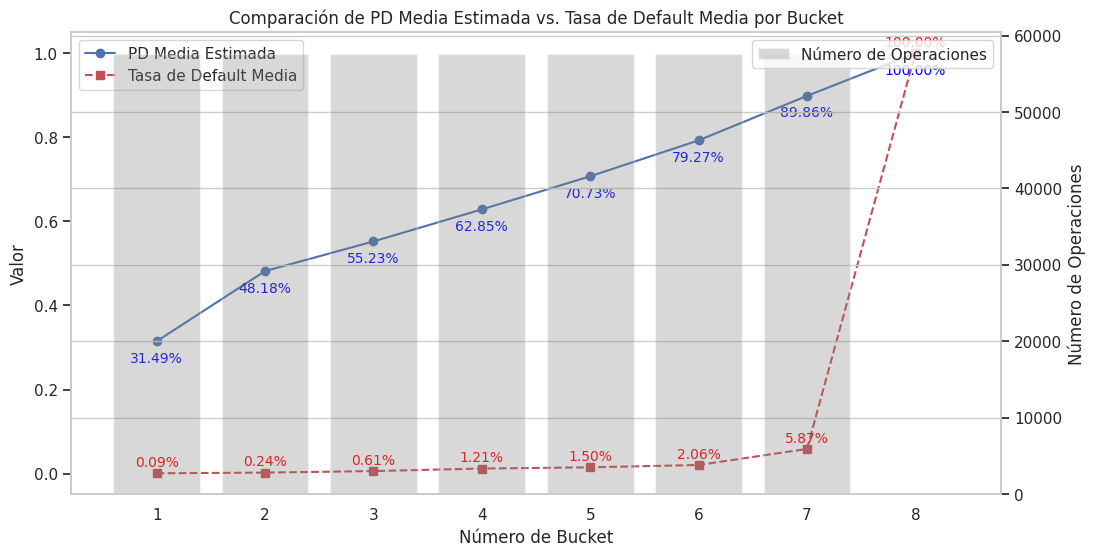

In [20]:
bucketizar_y_agregar_columna_por_bucket(df_PD_lr)

Número óptimo de clusters seleccionado automáticamente: 8


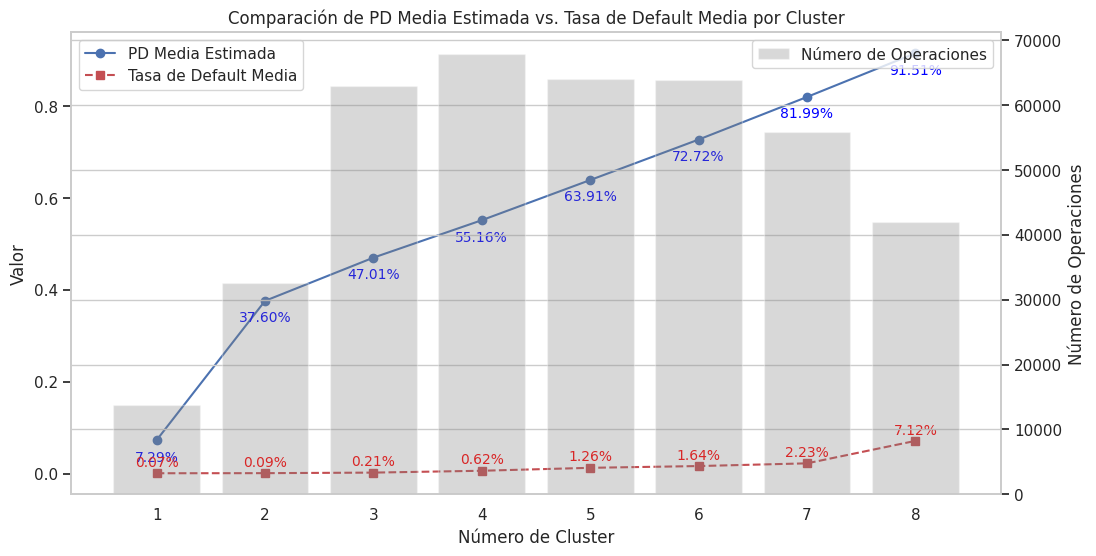

In [82]:
segmentar_por_cluster_y_visualizar(df_PD_lr)

In [84]:
df_PD_lr

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.000000,0.708891,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.942905,0,"(0.84059, 0.99997]",0.058727,7,8,0.071175
1,0.000000,0.175197,0.225000,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.624584,0,"(0.58911, 0.66791]",0.012093,4,5,0.012557
2,0.000000,0.085573,0.094853,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.530864,0,"(0.51756, 0.58911]",0.006116,3,4,0.006159
3,0.000000,0.202540,0.264706,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.214286,0.651728,0,"(0.58911, 0.66791]",0.012093,4,5,0.012557
4,0.000000,0.405081,0.558824,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.142857,0.784474,0,"(0.74732, 0.84059]",0.020571,6,7,0.022292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402884,0.132740,0.142902,0.264706,0.0,0.0,0.165740,0.105162,0.0,1.000000,1.000000,0.390964,0,"(0.00026179999999999997, 0.44257]",0.000921,1,2,0.000923
402885,0.318573,0.342967,0.676471,0.0,0.0,0.397778,0.252384,0.0,1.000000,1.000000,0.444955,0,"(0.44257, 0.51756]",0.002450,2,3,0.002127
402886,0.125985,0.225944,0.352941,0.0,0.0,0.310595,0.065875,0.0,1.000000,1.000000,0.669790,0,"(0.66791, 0.74732]",0.015029,5,5,0.012557
402887,0.126584,0.211600,0.323529,0.0,0.0,0.360564,0.055453,0.0,1.000000,1.000000,0.709053,0,"(0.66791, 0.74732]",0.015029,5,6,0.016389


<p style="color:red;">3.2 RANDOM FOREST

In [85]:
df_PD_rf['default'] = target_explot_PD
df_PD_rf.head(10)

,total_acc,out_prncp,pub_rec,out_prncp_inv,delinq_2yrs,total_rec_int,dti,inq_last_6mths,open_acc,funded_amnt_inv,...,total_pymnt_inv,total_pymnt,annual_inc,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.254545,0.708891,0.000000,0.708891,0.000000,0.0,0.000646,0.000000,0.197531,1.000000,...,0.0,0.0,0.013474,0.569005,0,"(0.492, 0.573]",0.013882,6,6,0.017319
1,0.121212,0.175197,0.000000,0.175197,0.000000,0.0,0.000728,0.000000,0.172840,0.227273,...,0.0,0.0,0.010526,0.420532,0,"(0.407, 0.492]",0.013822,5,4,0.013617
2,0.012121,0.085573,0.000000,0.085573,0.051282,0.0,0.001522,0.000000,0.061728,0.097507,...,0.0,0.0,0.003684,0.289892,0,"(0.273, 0.331]",0.012024,3,2,0.007467
3,0.115152,0.202540,0.000000,0.202540,0.000000,0.0,0.003104,0.166667,0.111111,0.266862,...,0.0,0.0,0.004474,0.466420,0,"(0.407, 0.492]",0.013822,5,5,0.014111
4,0.084848,0.405081,0.000000,0.405081,0.000000,0.0,0.001078,0.000000,0.061728,0.560117,...,0.0,0.0,0.006632,0.543223,0,"(0.492, 0.573]",0.013882,6,6,0.017319
5,0.163636,0.303811,0.023256,0.303811,0.000000,0.0,0.001389,0.166667,0.074074,0.413490,...,0.0,0.0,0.009684,0.498744,0,"(0.492, 0.573]",0.013882,6,5,0.014111
6,0.090909,0.506351,0.000000,0.506351,0.000000,0.0,0.002602,0.166667,0.098765,0.706745,...,0.0,0.0,0.011474,0.547147,0,"(0.492, 0.573]",0.013882,6,6,0.017319
7,0.054545,0.072915,0.000000,0.072915,0.000000,0.0,0.000591,0.166667,0.074074,0.079179,...,0.0,0.0,0.005789,0.271559,0,"(0.238, 0.273]",0.006342,2,2,0.007467
8,0.012121,0.242036,0.000000,0.242036,0.000000,0.0,0.001020,0.000000,0.049383,0.324047,...,0.0,0.0,0.003579,0.555408,0,"(0.492, 0.573]",0.013882,6,6,0.017319
9,0.260606,0.303811,0.000000,0.303811,0.000000,0.0,0.002018,0.166667,0.358025,0.413490,...,0.0,0.0,0.008421,0.527344,0,"(0.492, 0.573]",0.013882,6,5,0.014111


Versión manual

/tmp/ipykernel_1488/3326326277.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bucket = df.groupby('PD_bin')[default_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd_mean_by_bucket = df.groupby('PD_bin')[pd_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bucket = df.g

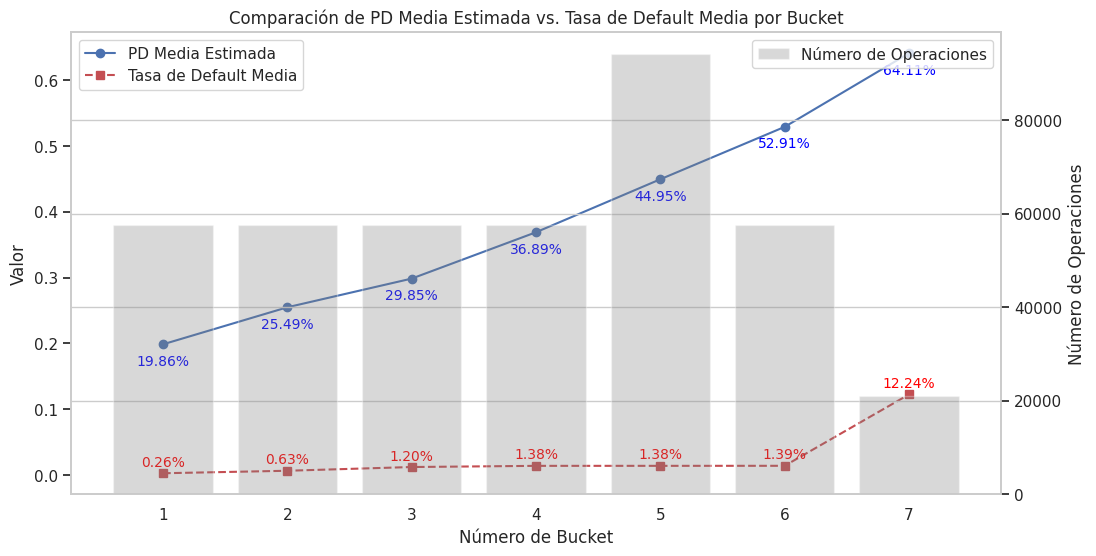

In [86]:
bucketizar_y_agregar_columna_por_bucket(df_PD_rf)

Versión clustering

Número óptimo de clusters seleccionado automáticamente: 7


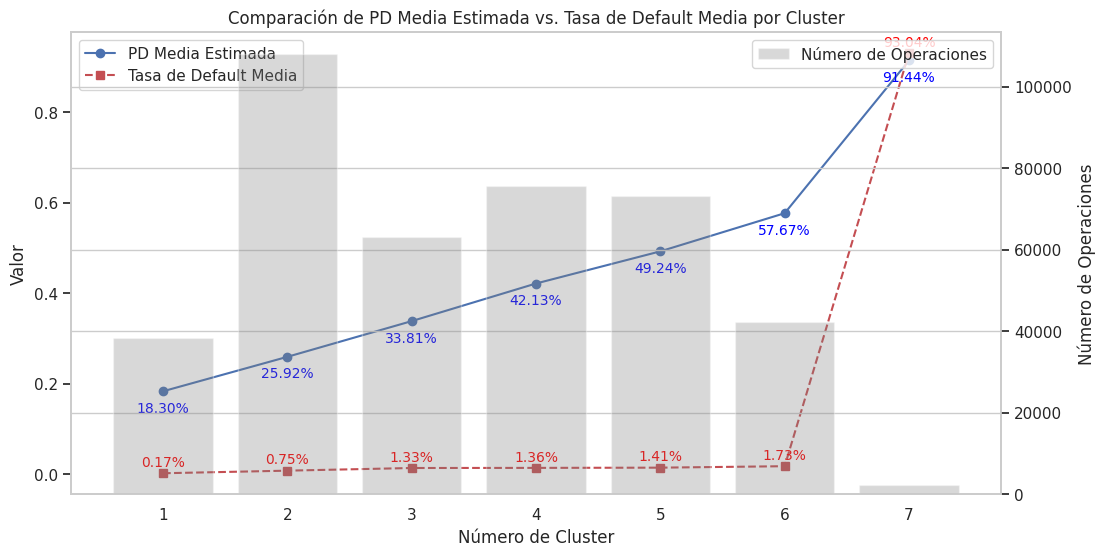

In [87]:
segmentar_por_cluster_y_visualizar(df_PD_rf)

In [88]:
df_PD_rf

,total_acc,out_prncp,pub_rec,out_prncp_inv,delinq_2yrs,total_rec_int,dti,inq_last_6mths,open_acc,funded_amnt_inv,...,total_pymnt_inv,total_pymnt,annual_inc,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
234096,0.054545,0.006606,0.011628,0.006606,0.025641,0.008955,0.000662,0.000000,0.098765,0.208211,...,0.258315,0.258315,0.012842,0.087466,0,"(0.0865, 0.238]",0.002554,1,1,0.001744
345586,0.139394,0.260211,0.000000,0.260211,0.025641,0.192275,0.002291,0.166667,0.148148,0.476540,...,0.183626,0.183626,0.006632,0.221049,0,"(0.0865, 0.238]",0.002554,1,1,0.001744
277804,0.133333,0.505602,0.000000,0.505602,0.000000,0.258592,0.000651,0.000000,0.135802,0.794721,...,0.155065,0.155065,0.015684,0.221051,0,"(0.0865, 0.238]",0.002554,1,1,0.001744
335916,0.096970,0.306162,0.000000,0.306162,0.000000,0.274481,0.002304,0.000000,0.160494,0.560117,...,0.220080,0.220080,0.005684,0.221055,0,"(0.0865, 0.238]",0.002554,1,1,0.001744
362382,0.115152,0.305547,0.000000,0.305547,0.000000,0.270266,0.002258,0.000000,0.123457,0.560117,...,0.220223,0.220223,0.005789,0.221055,0,"(0.0865, 0.238]",0.002554,1,1,0.001744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103967,0.290909,0.619390,0.000000,0.613982,0.000000,0.258179,0.002011,0.000000,0.382716,0.889296,...,0.083460,0.084195,0.007895,0.593474,0,"(0.573, 0.975]",0.122370,7,6,0.017319
40171,0.103030,0.600414,0.000000,0.600414,0.051282,0.028350,0.001026,0.000000,0.098765,0.853372,...,0.017766,0.017766,0.012632,0.593467,0,"(0.573, 0.975]",0.122370,7,6,0.017319
131188,0.175758,0.481836,0.000000,0.480363,0.051282,0.186987,0.001861,0.166667,0.259259,0.690616,...,0.063118,0.063312,0.009158,0.593455,0,"(0.573, 0.975]",0.122370,7,6,0.017319
79864,0.072727,0.592937,0.000000,0.592937,0.000000,0.098336,0.001219,0.000000,0.061728,0.853372,...,0.044601,0.044601,0.008224,0.593450,0,"(0.573, 0.975]",0.122370,7,6,0.017319


<p style="color:red;">3.3 XGBOOST

Agregamos la columna 'default' al df de XGBoost

In [89]:
df_PD_xgb['default'] = target_explot_PD
df_PD_xgb.head(10)

,funded_amnt,installment,out_prncp,out_prncp_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,term_months,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,1.000000,0.528679,0.708891,0.708891,0.0,0.0,0.0,0.0,0.0,1.0,0.083333,0.214286,0.999925,0,"(0.97, 1.0]",0.051101,7,6,0.046362
1,0.225000,0.162774,0.175197,0.175197,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.993458,0,"(0.97, 1.0]",0.051101,7,6,0.046362
2,0.094853,0.081987,0.085573,0.085573,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.734232,0,"(0.322, 0.97]",0.028573,6,7,0.057306
3,0.264706,0.135854,0.202540,0.202540,0.0,0.0,0.0,0.0,0.0,1.0,0.083333,0.214286,0.971217,0,"(0.97, 1.0]",0.051101,7,6,0.046362
4,0.558824,0.284412,0.405081,0.405081,0.0,0.0,0.0,0.0,0.0,1.0,0.083333,0.142857,0.998612,0,"(0.97, 1.0]",0.051101,7,6,0.046362
5,0.411765,0.319704,0.303811,0.303811,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.999717,0,"(0.97, 1.0]",0.051101,7,6,0.046362
6,0.705882,0.528092,0.506351,0.506351,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.999972,0,"(0.97, 1.0]",0.051101,7,6,0.046362
7,0.076471,0.065645,0.072915,0.072915,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.677343,0,"(0.322, 0.97]",0.028573,6,7,0.057306
8,0.322059,0.264996,0.242036,0.242036,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.999370,0,"(0.97, 1.0]",0.051101,7,6,0.046362
9,0.411765,0.297886,0.303811,0.303811,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.999552,0,"(0.97, 1.0]",0.051101,7,6,0.046362


versión manual

/tmp/ipykernel_1488/3326326277.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bucket = df.groupby('PD_bin')[default_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd_mean_by_bucket = df.groupby('PD_bin')[pd_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bucket = df.g

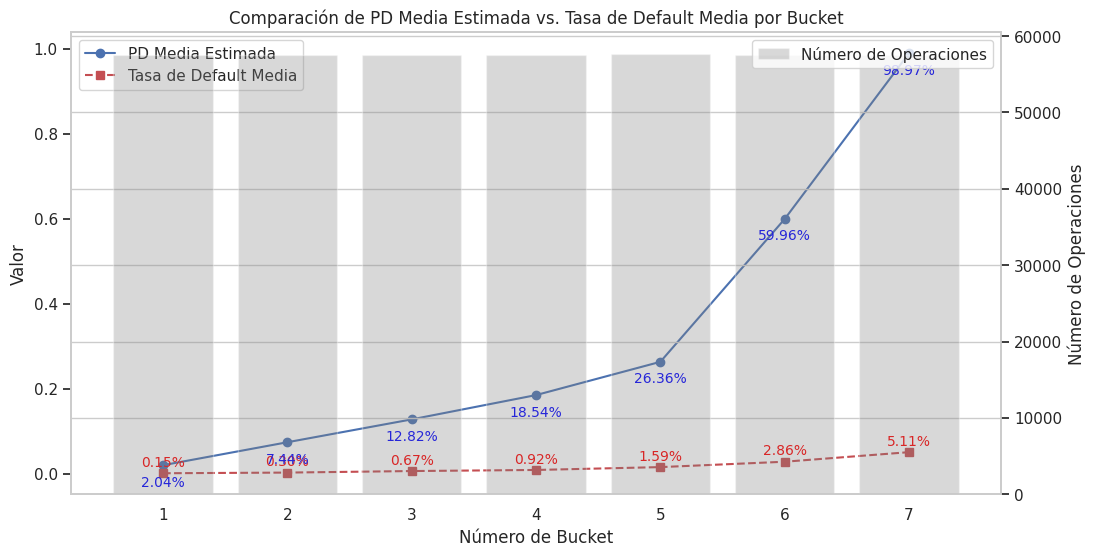

In [90]:
bucketizar_y_agregar_columna_por_bucket(df_PD_xgb)

versión clustering

Número óptimo de clusters seleccionado automáticamente: 7


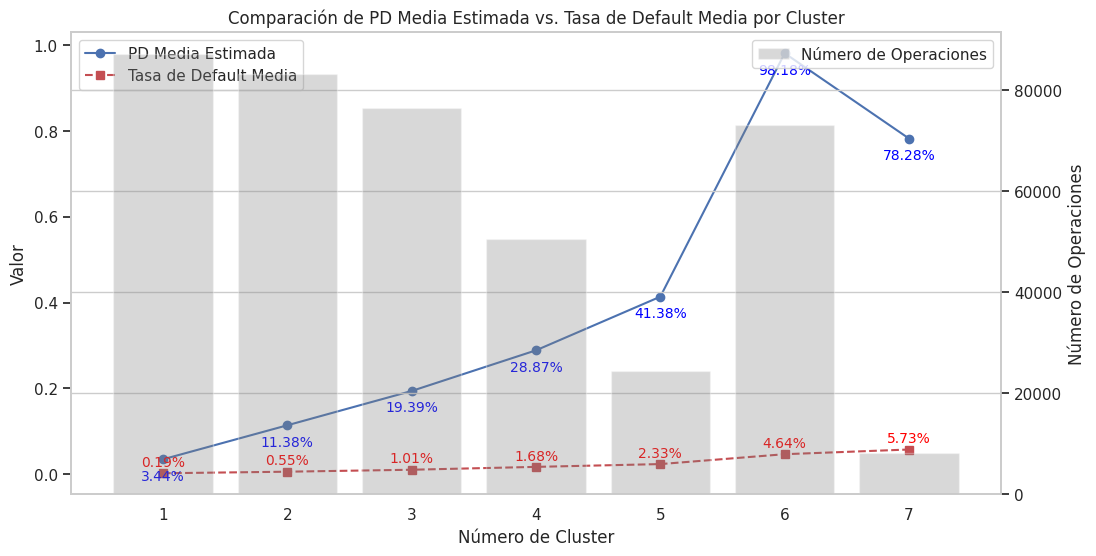

In [91]:
segmentar_por_cluster_y_visualizar(df_PD_xgb)

In [93]:
df_PD_xgb

,funded_amnt,installment,out_prncp,out_prncp_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,term_months,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
245322,0.111765,0.083846,0.000000,0.000000,0.171429,0.017467,0.0,0.0,0.128574,0.0,0.333333,0.428571,0.000003,0,"(-0.0009972100000000001, 0.0494]",0.001477,1,1,0.001917
103896,0.294118,0.229464,0.206661,0.206661,0.028448,0.042273,0.0,0.0,0.009924,0.0,0.250000,0.357143,0.030419,0,"(-0.0009972100000000001, 0.0494]",0.001477,1,1,0.001917
97157,0.300000,0.237759,0.210653,0.210653,0.028552,0.046262,0.0,0.0,0.010252,0.0,0.250000,0.357143,0.030419,0,"(-0.0009972100000000001, 0.0494]",0.001477,1,1,0.001917
110224,0.300000,0.237759,0.210653,0.210653,0.028552,0.045711,0.0,0.0,0.010252,0.0,0.250000,0.357143,0.030419,0,"(-0.0009972100000000001, 0.0494]",0.001477,1,1,0.001917
124461,0.305147,0.231238,0.213269,0.213269,0.030190,0.041189,0.0,0.0,0.009994,0.0,0.250000,0.357143,0.030419,0,"(-0.0009972100000000001, 0.0494]",0.001477,1,1,0.001917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35218,0.620588,0.353562,0.442617,0.442617,0.008812,0.054942,0.0,0.0,0.016951,1.0,0.083333,0.214286,0.987238,0,"(0.97, 1.0]",0.051101,7,6,0.046362
59403,0.747059,0.404850,0.528364,0.528364,0.011184,0.040542,0.0,0.0,0.016865,1.0,0.083333,0.214286,0.987243,0,"(0.97, 1.0]",0.051101,7,6,0.046362
27856,0.735294,0.398392,0.520359,0.520359,0.011015,0.039927,0.0,0.0,0.016609,1.0,0.083333,0.214286,0.987243,0,"(0.97, 1.0]",0.051101,7,6,0.046362
34192,0.323529,0.251346,0.237210,0.237210,0.010295,0.014695,0.0,0.0,0.010790,0.0,0.083333,0.214286,0.987232,0,"(0.97, 1.0]",0.051101,7,6,0.046362


<p style="color:red;">3.3 RED NEURONAL

In [94]:
df_PD_nn['default'] = target_explot_PD
df_PD_nn.head(10)

,revol_util,inq_last_6mths,purpose_wedding,tot_coll_amt,filtered_emp_title_operations,total_rec_late_fee,filtered_emp_title_other,out_prncp_inv,total_rec_int,last_pymnt_amnt,...,funded_amnt_inv,sub_grade_num,filtered_emp_title_technology,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.141969,0.000000,False,0.000646,False,0.0,False,0.708891,0.0,0.0,...,1.000000,0.312500,False,0.973103,0,"(0.874507, 0.999987]",0.052489,7,9,0.057074
1,0.138342,0.000000,False,0.000000,False,0.0,False,0.175197,0.0,0.0,...,0.227273,0.000000,False,0.583518,0,"(0.543861, 0.649683]",0.012457,4,5,0.011305
2,0.127461,0.000000,False,0.000000,False,0.0,False,0.085573,0.0,0.0,...,0.097507,0.375000,True,0.501357,0,"(0.438539, 0.543861]",0.008201,3,4,0.007992
3,0.211917,0.166667,False,0.000000,False,0.0,False,0.202540,0.0,0.0,...,0.266862,0.312500,True,0.632588,0,"(0.543861, 0.649683]",0.012457,4,6,0.014610
4,0.291192,0.000000,False,0.000000,True,0.0,False,0.405081,0.0,0.0,...,0.560117,0.203125,False,0.821395,0,"(0.75897, 0.874507]",0.020294,6,8,0.021971
5,0.182383,0.166667,False,0.000000,False,0.0,False,0.303811,0.0,0.0,...,0.413490,0.187500,False,0.837270,0,"(0.75897, 0.874507]",0.020294,6,8,0.021971
6,0.281347,0.166667,False,0.000000,False,0.0,False,0.506351,0.0,0.0,...,0.706745,0.046875,False,0.958881,0,"(0.874507, 0.999987]",0.052489,7,9,0.057074
7,0.153886,0.166667,False,0.001454,False,0.0,True,0.072915,0.0,0.0,...,0.079179,0.359375,False,0.457088,0,"(0.438539, 0.543861]",0.008201,3,4,0.007992
8,0.354404,0.000000,False,0.000000,False,0.0,True,0.242036,0.0,0.0,...,0.324047,0.343750,False,0.784589,0,"(0.75897, 0.874507]",0.020294,6,7,0.017652
9,0.110881,0.166667,False,0.000000,False,0.0,False,0.303811,0.0,0.0,...,0.413490,0.000000,False,0.810618,0,"(0.75897, 0.874507]",0.020294,6,8,0.021971


Versión manual

/tmp/ipykernel_1488/3326326277.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bucket = df.groupby('PD_bin')[default_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd_mean_by_bucket = df.groupby('PD_bin')[pd_col].mean().reset_index()
/tmp/ipykernel_1488/3326326277.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bucket = df.g

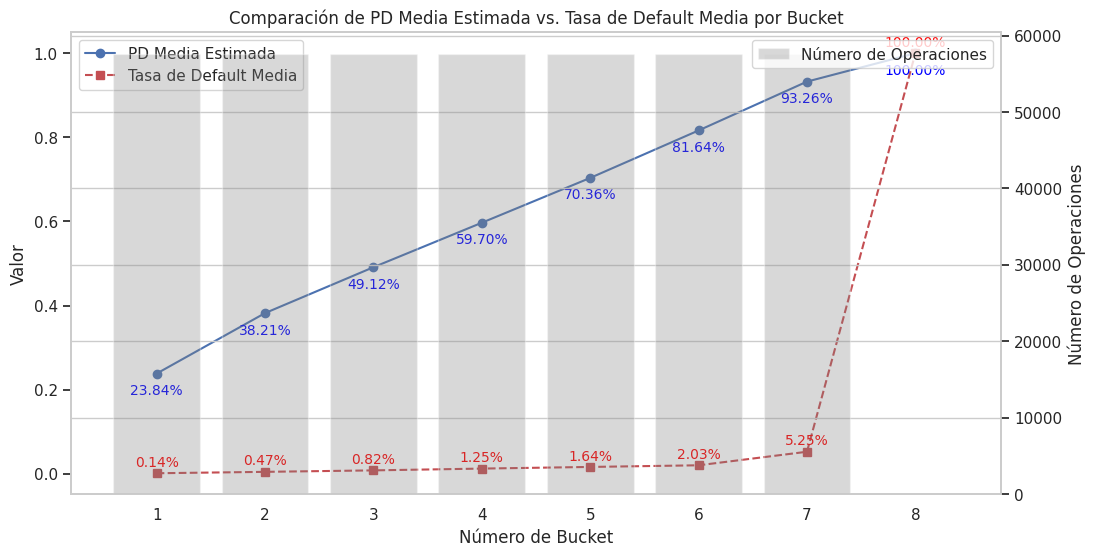

In [95]:
bucketizar_y_agregar_columna_por_bucket(df_PD_nn)

Versión clustering

Número óptimo de clusters seleccionado automáticamente: 9


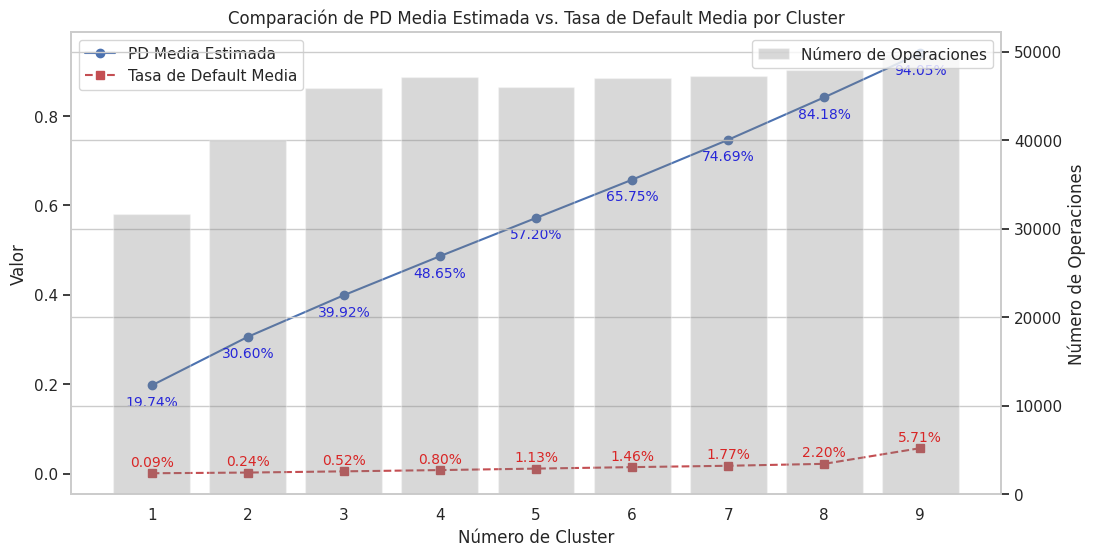

In [96]:
segmentar_por_cluster_y_visualizar(df_PD_nn)

In [34]:
df_PD_nn

,revol_util,inq_last_6mths,purpose_wedding,tot_coll_amt,filtered_emp_title_operations,total_rec_late_fee,filtered_emp_title_other,out_prncp_inv,total_rec_int,last_pymnt_amnt,...,funded_amnt_inv,sub_grade_num,filtered_emp_title_technology,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
179710,0.344041,0.666667,False,0.000226,False,0.0,False,0.000000,0.009875,0.099675,...,0.076246,0.515625,False,0.175646,0,"(0.175645, 0.321743]",0.001373,1,1,0.000914
288469,0.270466,0.166667,False,0.000000,False,0.0,False,0.080783,0.038004,0.004374,...,0.120235,0.062500,False,0.272404,0,"(0.175645, 0.321743]",0.001373,1,2,0.002449
230225,0.256995,0.000000,False,0.000000,False,0.0,True,0.315190,0.103116,0.009599,...,0.471408,0.062500,False,0.272405,0,"(0.175645, 0.321743]",0.001373,1,2,0.002449
180308,0.320725,0.000000,False,0.000000,False,0.0,False,0.042990,0.012496,0.002131,...,0.044721,0.156250,False,0.272409,0,"(0.175645, 0.321743]",0.001373,1,2,0.002449
374518,0.436269,0.166667,False,0.000354,False,0.0,True,0.107099,0.121136,0.006783,...,0.184751,0.328125,False,0.272418,0,"(0.175645, 0.321743]",0.001373,1,2,0.002449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302849,0.228497,0.000000,False,0.000000,False,0.0,False,0.575875,0.479760,0.033444,...,1.000000,0.359375,False,0.913539,0,"(0.874507, 0.999987]",0.052489,7,9,0.057074
286349,0.248705,0.000000,False,0.000000,False,0.0,False,0.000000,0.173900,0.034524,...,0.941349,0.671875,False,0.999992,1,"(0.999987, 0.999995]",1.000000,8,9,0.057074
279143,0.491710,0.000000,False,0.000000,False,0.0,True,0.000000,0.055729,0.022113,...,1.000000,0.328125,False,0.999989,1,"(0.999987, 0.999995]",1.000000,8,9,0.057074
349994,0.288083,0.000000,False,0.000000,False,0.0,False,0.000000,0.221742,0.033245,...,0.939883,0.531250,False,0.999990,1,"(0.999987, 0.999995]",1.000000,8,9,0.057074


### <p style="color:red;">4. VALIDACIÓN DE LOS BUCKETS</p>

<p style="color:red;">4.1. CONCENTRACIÓN

**Índice de Herfindahl-Hirschman (HHI)**

- El Índice de Herfindahl-Hirschman (HHI) mide la concentración de una distribución en distintas categorías.
- Se utiliza comúnmente en economía para evaluar la concentración del mercado, pero en este caso, sirve para evaluar si los datos están bien distribuidos entre los buckets o si hay una sobreconcentración en algunos de ellos.
- Valor del HHI:
    - Cercano a 0: Distribución uniforme de observaciones en los buckets (bien segmentado).
    - 0.10 - 0.25: Moderada concentración, distribución relativamente equitativa.
    - mayor a 0.25: Alta concentración en pocos buckets (riesgo de segmentación ineficaz).
    - Cercano a 1: La mayoría de los datos están en un solo bucket (segmentación deficiente). 

In [35]:
import numpy as np

def calcular_hhi(df, bucket_col="Cluster"):

    # Contar la cantidad de observaciones en cada bucket
    bucket_counts = df[bucket_col].value_counts(normalize=True)  # Proporciones
    
    # Calcular HHI como la suma de los cuadrados de las proporciones
    hhi = np.sum(bucket_counts ** 2)
    
    return hhi

<p style="color:blue;">4.1.1 Regresión logística

Moderada concentración, distribución relativamente equitativa.

In [36]:
calcular_hhi(df_PD_lr)

0.10758552059075528

<p style="color:blue;">4.1.2 Random Forest

Moderada concentración, distribución relativamente equitativa.

In [37]:
calcular_hhi(df_PD_rf)

0.18466676947039984

<p style="color:blue;">4.1.3 XGBoost

Moderada concentración, distribución relativamente equitativa.

In [38]:
calcular_hhi(df_PD_xgb)

0.17807193679459224

<p style="color:blue;">4.1.4 Neural Network

Moderada concentración, distribución relativamente equitativa.

In [39]:
calcular_hhi(df_PD_nn)

0.11263786673505878

<p style="color:red;">4.2. HOMOGENEIDAD INTRA-TRAMO

**T-test**:

- Evalúa si la media de la tasa de default dentro del bucket es estable cuando se divide en subconjuntos aleatorios.
- Se compara la media de dos o cuatro grupos seleccionados aleatoriamente dentro del bucket.
- Se considera que un p-valor bajo (< 0.05) indica falta de homogeneidad dentro del bucket.

In [40]:
def evaluar_homogeneidad_intrabucket(df, bucket_col='Cluster', value_col='default', min_samples=5):

    # Filtrar buckets con suficientes datos y eliminar valores NaN
    df = df.dropna(subset=[bucket_col, value_col])
    bucket_groups = {b: df[df[bucket_col] == b][value_col].values for b in df[bucket_col].unique()}
    bucket_groups = {b: g for b, g in bucket_groups.items() if len(g) >= min_samples}
    
    # Si no hay suficientes datos en los buckets, retornar None
    if not bucket_groups:
        print("No hay suficientes datos en los buckets para realizar el análisis.")
        return None
    
    # Pruebas de homogeneidad dentro de cada bucket: comparación de subconjuntos
    homogeneity_tests = {}
    for b, g in bucket_groups.items():
        if len(g) >= 4:
            np.random.shuffle(g)
            split_2 = np.array_split(g, 2)
            split_4 = np.array_split(g, 4)
            p_2 = ttest_ind(split_2[0], split_2[1], equal_var=False).pvalue
            p_4 = ttest_ind(split_4[0], split_4[1], equal_var=False).pvalue
            homogeneity_tests[b] = {'p_2_groups': p_2, 'p_4_groups': p_4}
    
    # Imprimir resultados
    print("\nPruebas de Homogeneidad dentro de cada Bucket (T-test entre subconjuntos):")
    for b, p_vals in homogeneity_tests.items():
        print(f"Bucket {b}: p-valor 2 grupos = {p_vals['p_2_groups']:.5f}, p-valor 4 grupos = {p_vals['p_4_groups']:.5f}")
    
    # return homogeneity_tests



<p style="color:blue;">4.2.1 Regresión logística

- Buckets con posible falta de homogeneidad interna:

    - Bucket 1 (p = 0.019 en 2 grupos) → Puede contener datos con diferencias significativas dentro del bucket.
    - Bucket 5 (p = 0.015 en 2 grupos) → Hay diferencia entre los subgrupos dentro del bucket.
    - Bucket 3 (p = 0.045 en 4 grupos) → Podría presentar cierta variabilidad interna.
    - Buckets con buena homogeneidad interna (p > 0.05 en ambas pruebas):

- Buckets 2, 6, 0, y 4 → No presentan diferencias significativas entre los subconjuntos.

In [41]:
evaluar_homogeneidad_intrabucket(df_PD_lr)


Pruebas de Homogeneidad dentro de cada Bucket (T-test entre subconjuntos):
Bucket 1: p-valor 2 grupos = 0.31727, p-valor 4 grupos = 0.56368
Bucket 2: p-valor 2 grupos = 0.02530, p-valor 4 grupos = 0.02008
Bucket 3: p-valor 2 grupos = 0.14529, p-valor 4 grupos = 0.44932
Bucket 4: p-valor 2 grupos = 0.73872, p-valor 4 grupos = 0.17946
Bucket 5: p-valor 2 grupos = 0.12512, p-valor 4 grupos = 0.54589
Bucket 6: p-valor 2 grupos = 0.66252, p-valor 4 grupos = 0.37756
Bucket 7: p-valor 2 grupos = 0.12436, p-valor 4 grupos = 0.03904
Bucket 8: p-valor 2 grupos = 0.47677, p-valor 4 grupos = 0.87461
Bucket 9: p-valor 2 grupos = 0.32917, p-valor 4 grupos = 0.49716
Bucket 10: p-valor 2 grupos = 0.54779, p-valor 4 grupos = 0.89226
Bucket 11: p-valor 2 grupos = 0.30465, p-valor 4 grupos = 0.97547


1. Homogeneidad confirmada:
    - Todos los p-valores son mayores a 0.05, lo que indica que los subconjuntos dentro de cada bucket no presentan diferencias significativas.
    - No hay suficiente evidencia para rechazar la hipótesis nula, lo que sugiere que los datos dentro de cada bucket son consistentes.
    - Bucket 5 y Bucket 2 tenían p-valores algo más bajos en la prueba de 4 grupos, pero siguen estando por encima de 0.05, lo que indica que no hay variabilidad preocupante.
2. No es necesario hacer ajustes en la segmentación actual, ya que los buckets parecen estar correctamente formados.



<p style="color:blue;">4.2.2 Random Forest

In [42]:
evaluar_homogeneidad_intrabucket(df_PD_rf)


Pruebas de Homogeneidad dentro de cada Bucket (T-test entre subconjuntos):
Bucket 1: p-valor 2 grupos = 0.01023, p-valor 4 grupos = 0.83493
Bucket 2: p-valor 2 grupos = 0.83180, p-valor 4 grupos = 0.54727
Bucket 3: p-valor 2 grupos = 0.10327, p-valor 4 grupos = 0.36437
Bucket 4: p-valor 2 grupos = 0.66050, p-valor 4 grupos = 0.92976
Bucket 5: p-valor 2 grupos = 0.47066, p-valor 4 grupos = 0.03155
Bucket 6: p-valor 2 grupos = 0.91151, p-valor 4 grupos = 0.40014
Bucket 7: p-valor 2 grupos = 0.74898, p-valor 4 grupos = 0.05290


Bucket 3 tiene un p-valor de 2 grupos de 0.01161, lo que indica posibles diferencias significativas dentro del bucket.
Esto significa que cuando se divide en 2 subconjuntos, hay una diferencia estadísticamente significativa entre los grupos. Sin embargo, cuando se divide en 4 subconjuntos, la diferencia desaparece (p-valor = 0.69098), lo que sugiere que el problema puede estar en una mala división de los datos en 2 partes

<p style="color:blue;">4.2.3 XGBoost

In [43]:
evaluar_homogeneidad_intrabucket(df_PD_xgb)


Pruebas de Homogeneidad dentro de cada Bucket (T-test entre subconjuntos):
Bucket 1: p-valor 2 grupos = 0.14115, p-valor 4 grupos = 0.91733
Bucket 2: p-valor 2 grupos = 0.67424, p-valor 4 grupos = 0.74361
Bucket 3: p-valor 2 grupos = 0.56274, p-valor 4 grupos = 0.75646
Bucket 4: p-valor 2 grupos = 0.13606, p-valor 4 grupos = 0.02701
Bucket 7: p-valor 2 grupos = 0.81035, p-valor 4 grupos = 0.09178
Bucket 6: p-valor 2 grupos = 0.42815, p-valor 4 grupos = 0.02759
Bucket 5: p-valor 2 grupos = 0.26924, p-valor 4 grupos = 0.02295


- Buckets 0, 1, 2, 4 y 6 son homogéneos → No hay evidencia de diferencias internas.
- Bucket 3 muestra diferencias cuando se divide en 4 grupos → Puede haber subgrupos dentro del bucket.
- Bucket 5 muestra diferencias cuando se divide en 2 grupos → Indica que el bucket podría estar compuesto de dos poblaciones distintas.

<p style="color:blue;">4.2.4 Neural Network

In [44]:
evaluar_homogeneidad_intrabucket(df_PD_nn)


Pruebas de Homogeneidad dentro de cada Bucket (T-test entre subconjuntos):
Bucket 1: p-valor 2 grupos = 0.57719, p-valor 4 grupos = 0.78144
Bucket 2: p-valor 2 grupos = 0.41860, p-valor 4 grupos = 0.33567
Bucket 3: p-valor 2 grupos = 0.00142, p-valor 4 grupos = 0.83658
Bucket 4: p-valor 2 grupos = 0.71769, p-valor 4 grupos = 0.77149
Bucket 5: p-valor 2 grupos = 0.99960, p-valor 4 grupos = 0.80300
Bucket 6: p-valor 2 grupos = 0.35667, p-valor 4 grupos = 0.82503
Bucket 7: p-valor 2 grupos = 0.77940, p-valor 4 grupos = 0.06625
Bucket 8: p-valor 2 grupos = 0.66281, p-valor 4 grupos = 0.54010
Bucket 9: p-valor 2 grupos = 0.48580, p-valor 4 grupos = 0.04484


- Buckets 0, 1, 3, 4 y 5 son homogéneos → No hay evidencia de diferencias internas.
- Bucket 2 muestra diferencias cuando se divide en 4 grupos → Puede haber subgrupos dentro del bucket.
- Bucket 6 está cerca del umbral de heterogeneidad en 2 grupos → Requiere análisis visual.

<p style="color:red;">4.3. HETEROGENEIDAD ENTRE TRAMOS

**Test de KRUSKAL-WALLIS (Diferencias en la mediana entre buckets)**
- ¿Qué mide?
    - Evalúa si la Tasa de Default es estadísticamente diferente entre los buckets.
    - Es una prueba no paramétrica, útil cuando los datos no siguen una distribución normal.
- Interpretación del p-valor:
    - p > 0.05 → No hay diferencias significativas entre los buckets (los buckets no están bien diferenciados).
    - **p < 0.05** → Existen diferencias significativas (la segmentación de los buckets es efectiva).
- ¿Por qué es útil en la estimaciónd de la PD?
    - Queremos que la PD promedio en cada bucket sea creciente y diferenciada, reflejando una segmentación adecuada del riesgo.
    - Si no hay diferencias significativas, puede indicar que los buckets no están bien definidos o que no reflejan adecuadamente el riesgo de default

**Pruebas de MANN-WHITNEY U (Diferencias por pares entre buckets)**
- ¿Qué mide?
    - Compara la distribución de la Tasa de Default entre dos buckets específicos.
    - Permite detectar qué buckets son realmente diferentes y cuáles podrían combinarse.
- Interpretación del p-valor
    - p > 0.05 → No hay diferencias significativas entre los dos buckets (podrían fusionarse).
    - **p < 0.05** → Existen diferencias significativas (los buckets están bien segmentados).
- ¿Por qué es útil en la estimaciónd de la PD?
    - Nos ayuda a validar si los buckets tienen sentido o si algunos están demasiado similares y deberían reagruparse.
    - Si muchos buckets no son significativamente diferentes, podría indicar que hay demasiados y que se necesita reducir su número.

In [45]:
def analizar_heterogeneidad_buckets(df, bucket_col='Cluster', value_col='default', min_samples=5):

    # Filtrar buckets con suficientes datos y eliminar valores NaN
    df = df.dropna(subset=[bucket_col, value_col])
    bucket_groups = {b: df[df[bucket_col] == b][value_col].values for b in df[bucket_col].unique()}
    bucket_groups = {b: g for b, g in bucket_groups.items() if len(g) >= min_samples}
    
    # Si hay menos de 2 grupos válidos, no se puede realizar el análisis
    if len(bucket_groups) < 2:
        print("No hay suficientes buckets con datos para realizar las pruebas.")
        return None
    
    groups_values = list(bucket_groups.values())
    
    # Prueba de Kruskal-Wallis (Alternativa no paramétrica a ANOVA)
    kruskal_test = kruskal(*groups_values)
    
    # Comparaciones por pares (Mann-Whitney U Test)
    mann_whitney_results = []
    bucket_labels = list(bucket_groups.keys())
    for i in range(len(bucket_labels)):
        for j in range(i+1, len(bucket_labels)):
            test_stat, p_value = mannwhitneyu(groups_values[i], groups_values[j], alternative='two-sided')
            mann_whitney_results.append((bucket_labels[i], bucket_labels[j], p_value))
    
    # Imprimir resultados
    print("\nPruebas de Heterogeneidad entre Buckets:")
    print(f"Kruskal-Wallis (no paramétrica): p-valor = {kruskal_test.pvalue:.5f}")
    
    print("\nComparaciones por pares (Mann-Whitney U Test):")
    for b1, b2, p in mann_whitney_results:
        print(f"{b1} vs {b2}: p-valor = {p:.5f}")
    
    return {
        'kruskal_pvalue': kruskal_test.pvalue,
        'mann_whitney_results': mann_whitney_results
    }

<p style="color:blue;">4.3.1 Regresión logística

1. Prueba de Kruskal-Wallis (p-valor = 0.00000)
    - Indica que existen diferencias significativas en la Tasa de Default entre los buckets.
    - Esto confirma que la segmentación separa correctamente los niveles de riesgo.
2. Pruebas de Mann-Whitney U (comparaciones por pares):
    - Solo el par 3 vs. 1 tiene un p-valor alto (0.58872), lo que indica que estos dos buckets no son estadísticamente diferentes.
    - Todas las demás comparaciones tienen p-valores cercanos a 0, lo que confirma que los buckets están bien diferenciados.

In [46]:
analizar_heterogeneidad_buckets(df_PD_lr)


Pruebas de Heterogeneidad entre Buckets:
Kruskal-Wallis (no paramétrica): p-valor = 0.00000

Comparaciones por pares (Mann-Whitney U Test):
1 vs 2: p-valor = 0.21908
1 vs 3: p-valor = 0.00736
1 vs 4: p-valor = 0.00455
1 vs 5: p-valor = 0.00000
1 vs 6: p-valor = 0.00000
1 vs 7: p-valor = 0.00000
1 vs 8: p-valor = 0.00000
1 vs 9: p-valor = 0.00000
1 vs 10: p-valor = 0.00000
1 vs 11: p-valor = 0.00000
2 vs 3: p-valor = 0.01225
2 vs 4: p-valor = 0.02273
2 vs 5: p-valor = 0.00000
2 vs 6: p-valor = 0.00000
2 vs 7: p-valor = 0.00000
2 vs 8: p-valor = 0.00000
2 vs 9: p-valor = 0.00000
2 vs 10: p-valor = 0.00000
2 vs 11: p-valor = 0.00000
3 vs 4: p-valor = 0.46486
3 vs 5: p-valor = 0.00000
3 vs 6: p-valor = 0.00000
3 vs 7: p-valor = 0.00000
3 vs 8: p-valor = 0.00000
3 vs 9: p-valor = 0.00000
3 vs 10: p-valor = 0.00000
3 vs 11: p-valor = 0.00000
4 vs 5: p-valor = 0.00539
4 vs 6: p-valor = 0.00000
4 vs 7: p-valor = 0.00000
4 vs 8: p-valor = 0.00000
4 vs 9: p-valor = 0.00000
4 vs 10: p-valor = 0.

{'kruskal_pvalue': 0.0,
 'mann_whitney_results': [(1, 2, 0.21907754816144454),
  (1, 3, 0.0073597344826307354),
  (1, 4, 0.004553538326626121),
  (1, 5, 5.449977072113335e-10),
  (1, 6, 7.552184319866834e-20),
  (1, 7, 8.177953626772052e-30),
  (1, 8, 7.13878164071953e-35),
  (1, 9, 2.7019915095588268e-45),
  (1, 10, 5.749560947088628e-58),
  (1, 11, 1.1361140723902889e-206),
  (2, 3, 0.012253891658624895),
  (2, 4, 0.022725209349654486),
  (2, 5, 1.1931628246939252e-18),
  (2, 6, 4.2941245446687626e-43),
  (2, 7, 2.6473237967219866e-68),
  (2, 8, 3.5762094588721554e-81),
  (2, 9, 1.6571002208551837e-107),
  (2, 10, 1.1187328149744783e-139),
  (2, 11, 0.0),
  (3, 4, 0.46485962059298325),
  (3, 5, 1.5762558803995409e-19),
  (3, 6, 5.019556866655774e-59),
  (3, 7, 1.684541320053148e-102),
  (3, 8, 3.881240533142263e-125),
  (3, 9, 5.671811166841521e-171),
  (3, 10, 7.409159874150917e-228),
  (3, 11, 0.0),
  (4, 5, 0.005393073773533111),
  (4, 6, 1.8099923518809187e-07),
  (4, 7, 3.599256

<p style="color:blue;">4.3.2 Random Forest

Los resultados indican que todos los buckets son significativamente diferentes entre sí (p-valor < 0.05 en todas las comparaciones).
1. Kruskal-Wallis (p = 0.00000)
    - Confirma que existen diferencias estadísticamente significativas en la Tasa de Default entre los diferentes buckets.
    - Esto es una buena señal, ya que sugiere que la segmentación está diferenciando bien los niveles de riesgo.
2. Mann-Whitney U (Comparaciones por pares)
    - Todos los pares de buckets tienen p-valores extremadamente bajos (p ≈ 0.00000), lo que indica que cada bucket es significativamente diferente de los demás.
    - La única comparación con un p-valor más alto es 3 vs 5 (p ≈ 0.00004), lo que sugiere que estos buckets podrían tener distribuciones similares, aunque aún significativamente diferentes.

In [47]:
analizar_heterogeneidad_buckets(df_PD_rf)


Pruebas de Heterogeneidad entre Buckets:
Kruskal-Wallis (no paramétrica): p-valor = 0.00000

Comparaciones por pares (Mann-Whitney U Test):
1 vs 2: p-valor = 0.00000
1 vs 3: p-valor = 0.00000
1 vs 4: p-valor = 0.00000
1 vs 5: p-valor = 0.00000
1 vs 6: p-valor = 0.00000
1 vs 7: p-valor = 0.00000
2 vs 3: p-valor = 0.00000
2 vs 4: p-valor = 0.00000
2 vs 5: p-valor = 0.00000
2 vs 6: p-valor = 0.00000
2 vs 7: p-valor = 0.00000
3 vs 4: p-valor = 0.65837
3 vs 5: p-valor = 0.22418
3 vs 6: p-valor = 0.00000
3 vs 7: p-valor = 0.00000
4 vs 5: p-valor = 0.41515
4 vs 6: p-valor = 0.00000
4 vs 7: p-valor = 0.00000
5 vs 6: p-valor = 0.00002
5 vs 7: p-valor = 0.00000
6 vs 7: p-valor = 0.00000


{'kruskal_pvalue': 0.0,
 'mann_whitney_results': [(1, 2, 6.636978530767865e-36),
  (1, 3, 1.0340284008515357e-80),
  (1, 4, 5.620176859315811e-84),
  (1, 5, 7.3917394093713e-88),
  (1, 6, 2.726166056041111e-110),
  (1, 7, 0.0),
  (2, 3, 3.298594351369564e-33),
  (2, 4, 7.783641800225822e-39),
  (2, 5, 1.5223357521599958e-43),
  (2, 6, 2.852041856783676e-65),
  (2, 7, 0.0),
  (3, 4, 0.6583667784674367),
  (3, 5, 0.22417728270755966),
  (3, 6, 1.7938314910888042e-07),
  (3, 7, 0.0),
  (4, 5, 0.41514808583419427),
  (4, 6, 5.000282072947653e-07),
  (4, 7, 0.0),
  (5, 6, 1.8686653156514992e-05),
  (5, 7, 0.0),
  (6, 7, 0.0)]}

<p style="color:blue;">4.3.3. XGBoost

Los resultados muestran que todos los buckets tienen diferencias estadísticamente significativas en la Tasa de Default, con p-valores cercanos a 0 en casi todas las comparaciones.
1. Kruskal-Wallis (p = 0.00000)
    - Confirma que los buckets están diferenciados en términos de Tasa de Default.
    - Es una señal de que la segmentación está funcionando bien.
2. Mann-Whitney U (Comparaciones por pares)
    - Casi todas las comparaciones muestran p < 0.05, lo que indica que cada bucket es significativamente diferente del resto.
    - La única comparación con un p-valor más alto es 1 vs 5 (p = 0.00001).→ Aunque sigue siendo muy bajo, esto podría indicar que estos dos buckets tienen distribuciones más similares entre sí.

In [48]:
analizar_heterogeneidad_buckets(df_PD_xgb)


Pruebas de Heterogeneidad entre Buckets:
Kruskal-Wallis (no paramétrica): p-valor = 0.00000

Comparaciones por pares (Mann-Whitney U Test):
1 vs 2: p-valor = 0.00000
1 vs 3: p-valor = 0.00000
1 vs 4: p-valor = 0.00000
1 vs 7: p-valor = 0.00000
1 vs 6: p-valor = 0.00000
1 vs 5: p-valor = 0.00000
2 vs 3: p-valor = 0.00000
2 vs 4: p-valor = 0.00000
2 vs 7: p-valor = 0.00000
2 vs 6: p-valor = 0.00000
2 vs 5: p-valor = 0.00000
3 vs 4: p-valor = 0.00000
3 vs 7: p-valor = 0.00000
3 vs 6: p-valor = 0.00000
3 vs 5: p-valor = 0.00000
4 vs 7: p-valor = 0.00000
4 vs 6: p-valor = 0.00000
4 vs 5: p-valor = 0.00000
7 vs 6: p-valor = 0.00001
7 vs 5: p-valor = 0.00000
6 vs 5: p-valor = 0.00000


{'kruskal_pvalue': 0.0,
 'mann_whitney_results': [(1, 2, 6.81132627094214e-35),
  (1, 3, 6.340141545593637e-106),
  (1, 4, 4.457810043646128e-212),
  (1, 7, 0.0),
  (1, 6, 0.0),
  (1, 5, 4.008664860761433e-291),
  (2, 3, 2.0985859525785236e-25),
  (2, 4, 2.365553913225031e-91),
  (2, 7, 0.0),
  (2, 6, 0.0),
  (2, 5, 1.11089459536589e-138),
  (3, 4, 2.8616175578511283e-25),
  (3, 7, 2.1752820990580772e-250),
  (3, 6, 0.0),
  (3, 5, 2.8018858960866776e-55),
  (4, 7, 7.654352135483988e-117),
  (4, 6, 2.368828707382263e-173),
  (4, 5, 9.208234320751869e-10),
  (7, 6, 9.685265005519287e-06),
  (7, 5, 5.065870679756924e-52),
  (6, 5, 3.1417957458563444e-56)]}

<p style="color:blue;">4.3.4. Red neuronal

In [49]:
analizar_heterogeneidad_buckets(df_PD_nn)


Pruebas de Heterogeneidad entre Buckets:
Kruskal-Wallis (no paramétrica): p-valor = 0.00000

Comparaciones por pares (Mann-Whitney U Test):
1 vs 2: p-valor = 0.00000
1 vs 3: p-valor = 0.00000
1 vs 4: p-valor = 0.00000
1 vs 5: p-valor = 0.00000
1 vs 6: p-valor = 0.00000
1 vs 7: p-valor = 0.00000
1 vs 8: p-valor = 0.00000
1 vs 9: p-valor = 0.00000
2 vs 3: p-valor = 0.00000
2 vs 4: p-valor = 0.00000
2 vs 5: p-valor = 0.00000
2 vs 6: p-valor = 0.00000
2 vs 7: p-valor = 0.00000
2 vs 8: p-valor = 0.00000
2 vs 9: p-valor = 0.00000
3 vs 4: p-valor = 0.00000
3 vs 5: p-valor = 0.00000
3 vs 6: p-valor = 0.00000
3 vs 7: p-valor = 0.00000
3 vs 8: p-valor = 0.00000
3 vs 9: p-valor = 0.00000
4 vs 5: p-valor = 0.00000
4 vs 6: p-valor = 0.00000
4 vs 7: p-valor = 0.00000
4 vs 8: p-valor = 0.00000
4 vs 9: p-valor = 0.00000
5 vs 6: p-valor = 0.00001
5 vs 7: p-valor = 0.00000
5 vs 8: p-valor = 0.00000
5 vs 9: p-valor = 0.00000
6 vs 7: p-valor = 0.00021
6 vs 8: p-valor = 0.00000
6 vs 9: p-valor = 0.00000
7

{'kruskal_pvalue': 0.0,
 'mann_whitney_results': [(1, 2, 1.1920875757332088e-06),
  (1, 3, 2.4769003796325672e-23),
  (1, 4, 2.913595125977638e-42),
  (1, 5, 8.23267714198399e-65),
  (1, 6, 9.087589133628344e-88),
  (1, 7, 5.4329962637523385e-109),
  (1, 8, 2.2094864124989905e-139),
  (1, 9, 0.0),
  (2, 3, 2.0277592989342735e-10),
  (2, 4, 1.5764280882541563e-28),
  (2, 5, 4.262229507536942e-53),
  (2, 6, 8.569341027524893e-80),
  (2, 7, 4.5358475096198e-105),
  (2, 8, 5.8773967366596986e-142),
  (2, 9, 0.0),
  (3, 4, 9.231436272286634e-08),
  (3, 5, 6.210604515238577e-25),
  (3, 6, 8.065709388493916e-48),
  (3, 7, 1.4158119534433808e-71),
  (3, 8, 2.0101628451305066e-108),
  (3, 9, 0.0),
  (4, 5, 2.2503057723904363e-07),
  (4, 6, 7.047517710828176e-22),
  (4, 7, 1.0029277117941357e-39),
  (4, 8, 3.322973624426209e-70),
  (4, 9, 0.0),
  (5, 6, 8.365966225448044e-06),
  (5, 7, 5.469601728710507e-16),
  (5, 8, 3.6988350737308846e-37),
  (5, 9, 0.0),
  (6, 7, 0.00020935940442523335),
  (6

<p style="color:red;">4.4. MONOTONÍA

Que la tasa de impago de cada bucket vaya creciendo a medida que avanzamos con los buckets es una condición que hemos impuesto en el código en la creación de los buckets

<p style="color:red;">4.5. SUFICIENCIA MUESTRAL

La PD mínima por bucket debe ser del 0,03%, condición que también se cumple tanto en la creación de buckets manual como en la creación de buckets mediante K-means.

### <p style="color:red;">5. PD FINAL POR MODELO</p>

<p style="color:red;">5.1. LOGISTIC REGRESSION

In [50]:
df_PD_lr = df_PD_lr.sort_index()

In [51]:
df_PD_lr.head(2)

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.0,0.708891,1.000,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.942905,0,"(0.84059, 0.99997]",0.058727,7,11,0.085884
1,0.0,0.175197,0.225,0.0,0.0,0.0,0.0,0.0,0.083333,0.214286,0.624584,0,"(0.58911, 0.66791]",0.012093,4,7,0.013124


En la regresión logística, empleando la técnica de creación de buckets de forma manual, al aplicar el código para crear automáticamente los buckets, se generó un bucket adiccional para sólo 4 muestras. Pese a que no va a afectar prácticamente en el cálculo de la PD de la cartera, vamos a solucionarlo asignando la PD del bucket 7 al bucket 8 creado adicionalmente.

In [52]:
df_PD_lr["default_media_bucket"].nunique()

8

In [53]:
df_PD_lr[df_PD_lr["Bucket_Num"]==8]

,total_pymnt,out_prncp,funded_amnt,total_rec_late_fee,recoveries,total_rec_int,total_rec_prncp,collection_recovery_fee,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
279143,0.025604,0.0,1.0,0.0,0.0,0.055729,0.015025,0.0,0.166667,0.714286,0.999977,1,"(0.99997, 0.99998]",1.0,8,11,0.085884
356086,0.076977,0.0,1.0,0.0,0.0,0.163662,0.046030,0.0,0.250000,0.928571,0.999981,1,"(0.99997, 0.99998]",1.0,8,11,0.085884
368214,0.082778,0.0,1.0,0.0,0.0,0.198980,0.044411,0.0,0.250000,0.857143,0.999980,1,"(0.99997, 0.99998]",1.0,8,11,0.085884
392066,0.142681,0.0,1.0,0.0,0.0,0.374263,0.069623,0.0,0.416667,0.928571,0.999976,1,"(0.99997, 0.99998]",1.0,8,11,0.085884


In [54]:
# Obtener el valor de default_media_bucket para Bucket_Num == 7
valor_bucket_7 = df_PD_lr.loc[df_PD_lr["Bucket_Num"] == 7, "default_media_bucket"].values[0]
valor_bucket_7

0.05872745595440804

In [55]:
# Aplicar los cambios a las filas con Bucket_Num == 8
df_PD_lr.loc[df_PD_lr["Bucket_Num"] == 8, "default_media_bucket"] = valor_bucket_7
df_PD_lr.loc[df_PD_lr["Bucket_Num"] == 8, "Bucket_Num"] = 7

Comprobamos que sólo tenemos 7 buckets

In [56]:
df_PD_lr["default_media_bucket"].nunique()

7

Guardamos el df de estimación de PD mediante regresión logística final.

In [57]:
df_PD_lr.to_csv("df_PD_lr_final.csv")

<p style="color:red;">5.2. RANDOM FOREST

In [58]:
df_PD_rf = df_PD_rf.sort_index()

In [59]:
df_PD_rf.head(1)

,total_acc,out_prncp,pub_rec,out_prncp_inv,delinq_2yrs,total_rec_int,dti,inq_last_6mths,open_acc,funded_amnt_inv,...,total_pymnt_inv,total_pymnt,annual_inc,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.254545,0.708891,0.0,0.708891,0.0,0.0,0.000646,0.0,0.197531,1.0,...,0.0,0.0,0.013474,0.569005,0,"(0.492, 0.573]",0.013882,6,6,0.017319


In [60]:
df_PD_rf["default_media_bucket"].nunique()

7

In [61]:
df_PD_rf.to_csv("df_PD_rf_final.csv")

<p style="color:red;">5.3. XGBOOST

In [62]:
df_PD_xgb = df_PD_xgb.sort_index()

In [63]:
df_PD_xgb.head(1)

,funded_amnt,installment,out_prncp,out_prncp_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,term_months,months_last_pymnt_date,months_last_credit_pull_date,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,1.0,0.528679,0.708891,0.708891,0.0,0.0,0.0,0.0,0.0,1.0,0.083333,0.214286,0.999925,0,"(0.97, 1.0]",0.051101,7,6,0.046362


In [64]:
df_PD_xgb["default_media_bucket"].nunique()

7

In [65]:
df_PD_xgb.to_csv("df_PD_xgb_final.csv")

<p style="color:red;">5.4. NEURAL NETWORKS

In [66]:
df_PD_nn = df_PD_nn.sort_index()

In [67]:
df_PD_nn.head(1)

,revol_util,inq_last_6mths,purpose_wedding,tot_coll_amt,filtered_emp_title_operations,total_rec_late_fee,filtered_emp_title_other,out_prncp_inv,total_rec_int,last_pymnt_amnt,...,funded_amnt_inv,sub_grade_num,filtered_emp_title_technology,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
0,0.141969,0.0,False,0.000646,False,0.0,False,0.708891,0.0,0.0,...,1.0,0.3125,False,0.973103,0,"(0.874507, 0.999987]",0.052489,7,9,0.057074


In [68]:
df_PD_nn["default_media_bucket"].nunique()

8

In [69]:
df_PD_nn[df_PD_nn["Bucket_Num"]==8]

,revol_util,inq_last_6mths,purpose_wedding,tot_coll_amt,filtered_emp_title_operations,total_rec_late_fee,filtered_emp_title_other,out_prncp_inv,total_rec_int,last_pymnt_amnt,...,funded_amnt_inv,sub_grade_num,filtered_emp_title_technology,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
262198,0.338342,0.166667,False,0.000145,False,0.0,False,0.0,0.160692,0.035313,...,1.000000,0.531250,False,0.999995,1,"(0.999987, 0.999995]",1.0,8,9,0.057074
279143,0.491710,0.000000,False,0.000000,False,0.0,True,0.0,0.055729,0.022113,...,1.000000,0.328125,False,0.999989,1,"(0.999987, 0.999995]",1.0,8,9,0.057074
286349,0.248705,0.000000,False,0.000000,False,0.0,False,0.0,0.173900,0.034524,...,0.941349,0.671875,False,0.999992,1,"(0.999987, 0.999995]",1.0,8,9,0.057074
349994,0.288083,0.000000,False,0.000000,False,0.0,False,0.0,0.221742,0.033245,...,0.939883,0.531250,False,0.999990,1,"(0.999987, 0.999995]",1.0,8,9,0.057074


In [70]:
# Obtener el valor de default_media_bucket para Bucket_Num == 7
valor_bucket_7 = df_PD_nn.loc[df_PD_nn["Bucket_Num"] == 7, "default_media_bucket"].values[0]
valor_bucket_7

0.05248892363825906

In [71]:
# Aplicar los cambios a las filas con Bucket_Num == 8
df_PD_nn.loc[df_PD_nn["Bucket_Num"] == 8, "default_media_bucket"] = valor_bucket_7
df_PD_nn.loc[df_PD_nn["Bucket_Num"] == 8, "Bucket_Num"] = 7

Comprobamos que sólo tenemos 7 buckets

In [72]:
df_PD_nn["default_media_bucket"].nunique()

7

Guardamos el df de estimación de PD mediante regresión logística final.

In [73]:
df_PD_nn.to_csv("df_PD_nn_final.csv")

In [74]:
# Obtener el valor de default_media_bucket para Bucket_Num == 7
valor_bucket_7 = df_PD_lr.loc[df_PD_lr["Bucket_Num"] == 7, "default_media_bucket"].values[0]
valor_bucket_7

0.05872745595440804

In [75]:
# Aplicar los cambios a las filas con Bucket_Num == 8
df_PD_lr.loc[df_PD_lr["Bucket_Num"] == 8, "default_media_bucket"] = valor_bucket_7
df_PD_lr.loc[df_PD_lr["Bucket_Num"] == 8, "Bucket_Num"] = 7

Comprobamos que sólo tenemos 7 buckets

In [76]:
df_PD_lr["default_media_bucket"].nunique()

7

Guardamos el df de estimación de PD mediante regresión logística final.

In [77]:
df_PD_lr.to_csv("df_PD_lr_final.csv")

In [78]:
df_PD_nn[df_PD_nn["Bucket_Num"]==2]

,revol_util,inq_last_6mths,purpose_wedding,tot_coll_amt,filtered_emp_title_operations,total_rec_late_fee,filtered_emp_title_other,out_prncp_inv,total_rec_int,last_pymnt_amnt,...,funded_amnt_inv,sub_grade_num,filtered_emp_title_technology,PD_estimada,default,PD_bin,default_media_bucket,Bucket_Num,Cluster,default_media_cluster
21,0.161140,0.666667,False,0.000000,False,0.0,False,0.050635,0.000000,0.000000,...,0.046921,0.500000,False,0.399244,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
41,0.148705,0.333333,False,0.000391,False,0.0,False,0.072915,0.000000,0.000000,...,0.079179,0.218750,False,0.435070,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
164,0.292228,0.000000,False,0.000000,False,0.0,False,0.060762,0.000000,0.000000,...,0.061584,0.218750,False,0.401449,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
176,0.042487,0.166667,False,0.000000,False,0.0,False,0.050635,0.000000,0.000000,...,0.046921,0.218750,False,0.402706,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
178,0.035233,0.166667,False,0.000000,False,0.0,True,0.040508,0.000000,0.000000,...,0.032258,0.156250,False,0.337577,0,"(0.321743, 0.438539]",0.004708,2,2,0.002449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402863,0.294819,0.000000,False,0.000000,True,0.0,False,0.256044,0.254222,0.009212,...,0.413490,0.203125,False,0.370242,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
402865,0.129016,0.000000,False,0.000000,False,0.0,False,0.378530,0.302838,0.023681,...,0.763930,0.062500,False,0.433647,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
402883,0.336788,0.000000,False,0.000000,False,0.0,False,0.168038,0.255680,0.011314,...,0.313050,0.468750,False,0.340486,0,"(0.321743, 0.438539]",0.004708,2,2,0.002449
402886,0.317617,0.000000,False,0.000000,False,0.0,True,0.225944,0.310595,0.008838,...,0.354839,0.484375,False,0.436610,0,"(0.321743, 0.438539]",0.004708,2,3,0.005158
